In [16]:
# Set up the environment and define functions

# Import packages
import gc
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as op
import time
import pandas as pd
import glob
import csv
import mne
from mne.preprocessing.nirs import tddr
from nilearn.glm.first_level import make_first_level_design_matrix  
from mne_nirs.channels import get_long_channels
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from scipy import signal
from scipy.stats import ttest_rel, zscore
import mne_nirs

mne.viz.set_browser_backend('matplotlib')

######### Set these variables as appropriate:
raw_path = '../../data'
proc_path = '../../processed'
results_path = '../../results'
subjects_dir = '../../subjects'
subject_group_mapping = pd.read_csv('../../subject_group_mapping.csv')
behavior_results_path = '../../fnirs-behavior-results'
behavior_file = '../../behavior_diff_data.csv'
output_suffix = "final" # used for all file names that are created

# Create the subject to group mapping dictionary
subject_group_mapping = subject_group_mapping.dropna(subset=['Subject'])  
subject_group_mapping['Subject'] = subject_group_mapping['Subject'].astype(int) 
subject_to_group = dict(zip(subject_group_mapping['Subject'], subject_group_mapping['Group']))
subjects = subject_group_mapping['Subject'].astype(str).tolist()

sfreq = 4.807692
conditions = ('A', 'V', 'AV', 'W')
groups = ('trained', 'control')
days = ('1', '3')
runs = (1, 2)
duration = 1.8
design = 'event'
filt_kwargs = dict(
    l_freq=0.01, l_trans_bandwidth=0.01,
    h_freq=0.2, h_trans_bandwidth=0.01)
n_jobs = 4  # for GLM

os.makedirs(proc_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(subjects_dir, exist_ok=True)
# mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir, verbose=True)  # Only need to run once

use = None
all_sci = list()
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Prep making bad channels report
bad_channels_filename = op.join(results_path, f'bad_channels_report_{output_suffix}.csv')

with open(bad_channels_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Subject', 'Day', 'Run', 'Percent Bad'])

def add_bad_channel_entry(subject, day, run, percentage_bad):
    with open(bad_channels_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([subject, day, run, f'{percentage_bad:.2f}%'])

def normalize_channel_names(channels_set):
    return {name.split()[0] for name in channels_set}

# Sanity check for subjects
subjects_check = {int(subject) for subject in subjects}
subject_to_group_check = set(subject_to_group.keys())
if subjects_check == subject_to_group_check:
    print("N=" + str(len(subjects)))
    del subjects_check, subject_to_group_check
else:
    print("Error loading subject info") 

Using matplotlib as 2D backend.
N=29


In [17]:
# Set parameters for preprocessing

def preprocess_fnirs_data(raw_intensity, proc_path, base):
    # 1. Convert to optical density:
    print(f'    Analyzing {base}')
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity, verbose='error')

    # 2. Identify bad channels based on flat signal and scalp coupling index:
    peaks = np.ptp(raw_od.get_data('fnirs'), axis=-1)
    flat_names = [raw_od.ch_names[f].split(' ')[0] for f in np.where(peaks < 0.001)[0]]
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    sci_mask = (sci < 0.25)
    got = np.where(sci_mask)[0]
    percentage_bad = (len(got) / len(raw_od.ch_names)) * 100
    assert raw_od.info['bads'] == []
    bads = set(raw_od.ch_names[pick] for pick in got)
    bads = bads | set(ch_name for ch_name in raw_od.ch_names if ch_name.split(' ')[0] in flat_names)
    bads = sorted(bads)

    # 3. Apply temporal derivative distribution repair (TDDR), bandpass filter, apply bad channels:
    raw_tddr = tddr(raw_od)
    raw_tddr_bp = raw_tddr.copy().filter(**filt_kwargs)
    raw_tddr_bp.info['bads'] = bads

    # 5. Short channel regression (if present): 
    try:
        raw_tddr_bp = mne_nirs.signal_enhancement.short_channel_regression(raw_tddr_bp)
    except:
        print(f"No short channels found for {base}.")

    # 6. Convert to hemoglobin concentration:
    raw_h = mne.preprocessing.nirs.beer_lambert_law(raw_tddr_bp, 6.)

    # 7. Normalize channel names and verify bad channels
    h_bads = [ch_name for ch_name in raw_h.ch_names if ch_name.split(' ')[0] in set(bad.split(' ')[0] for bad in bads)]
    raw_h.info['bads'] = h_bads
    raw_h.info._check_consistency()

    # 8. Select long channels and verify that the signal is not flat:
    raw_h = get_long_channels(raw_h)
    picks = mne.pick_types(raw_h.info, fnirs=True)
    peaks = np.ptp(raw_h.get_data(picks), axis=-1)
    assert (peaks > 1e-9).all()

    # 9. Interpolate bad channels
    raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))
    raw_h_interp.save(op.join(proc_path, f'{subject}_{day}_{run:03d}_long_hbo_{output_suffix}_raw.fif'), overwrite=True)
    assert len(raw_h.ch_names) == len(raw_h_interp.ch_names)

    return raw_h_interp, percentage_bad, bads

In [18]:
# Load participant data

#subjects = ['223'] #testing

for subject in subjects:
    for day in days:
        for run in runs:
            group = subject_to_group.get(int(subject), "unknown")
            root1 = f'Day{day}'
            root2 = f'{subject}_{day}'
            root3 = f'*-*-*_{run:03d}'
            fname_base = op.join(raw_path, root1, root2, root3)
            fname = glob.glob(fname_base)
            base = f'{subject}_{day}_{run:03d}'
            base_pr = base.ljust(20)
            raw_intensity = mne.io.read_raw_nirx(fname[0])
            raw_intensity, percentage_bad_long, bads_long = preprocess_fnirs_data(raw_intensity, proc_path, base + '_long')
            add_bad_channel_entry(subject, day, run, percentage_bad_long)
            del raw_intensity, percentage_bad_long, bads_long
            gc.collect()  


Loading ../../data/Day1/201_1/2023-09-21_001
    Analyzing 201_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 201_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/201_1/2023-09-21_002
    Analyzing 201_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels fou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/201_3/2023-09-23_001
    Analyzing 201_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels fou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/201_3/2023-09-23_002
    Analyzing 201_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/202_1/2023-10-03_001
    Analyzing 202_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 202_1_001_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/202_1/2023-10-03_002
    Analyzing 202_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels fou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/202_3/2023-10-05_001
    Analyzing 202_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/202_3/2023-10-05_002
    Analyzing 202_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 202_3_002_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/203_1/2023-10-06_001
    Analyzing 203_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


No short channels found for 203_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/203_1/2023-10-06_002
    Analyzing 203_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/203_3/2023-10-08_001
    Analyzing 203_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/203_3/2023-10-08_002
    Analyzing 203_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels fou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/204_1/2023-10-07_001
    Analyzing 204_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


No short channels found for 204_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/204_1/2023-10-07_002
    Analyzing 204_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/204_3/2023-10-09_001
    Analyzing 204_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/204_3/2023-10-09_002
    Analyzing 204_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


No short channels found for 204_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s


    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/205_1/2023-10-13_001
    Analyzing 205_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 205_1_001_long.
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/205_1/2023-10-13_002
    Analyzing 205_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 205_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_1_002_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/205_3/2023-10-15_001
    Analyzing 205_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 205_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/205_3/2023-10-15_002
    Analyzing 205_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


No short channels found for 205_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_3_002_long_hbo_final_raw.fif


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/206_1/2023-10-14_001
    Analyzing 206_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 206_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/206_1/2023-10-14_002
    Analyzing 206_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 206_1_002_long.
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/206_3/2023-10-16_001
    Analyzing 206_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels fou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/206_3/2023-10-16_002
    Analyzing 206_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/207_1/2023-10-17_001
    Analyzing 207_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 207_1_001_long.
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/207_1/2023-10-17_002
    Analyzing 207_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 207_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_1_002_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/207_3/2023-10-19_001
    Analyzing 207_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 207_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_3_001_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/207_3/2023-10-19_002
    Analyzing 207_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


No short channels found for 207_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_3_002_long_hbo_final_raw.fif
[done]


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Loading ../../data/Day1/208_1/2023-10-23_001
    Analyzing 208_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 208_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_1_001_long_hbo_final_raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/208_1/2023-10-23_002
    Analyzing 208_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 208_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_1_002_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/208_3/2023-10-25_001
    Analyzing 208_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 208_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_3_001_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/208_3/2023-10-25_002
    Analyzing 208_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 208_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_3_002_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/209_1/2023-10-26_001
    Analyzing 209_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 209_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/209_1/2023-10-26_002
    Analyzing 209_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels fou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/209_3/2023-10-28_001
    Analyzing 209_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 209_3_001_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/209_3/2023-10-28_002
    Analyzing 209_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 209_3_002_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/212_1/2023-11-07_001
    Analyzing 212_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 212_1_001_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/212_1/2023-11-07_002
    Analyzing 212_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 212_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_1_002_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/212_3/2023-11-09_001
    Analyzing 212_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 212_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_3_001_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/212_3/2023-11-09_002
    Analyzing 212_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 212_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_3_002_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/213_1/2023-12-04_001
    Analyzing 213_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 213_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/213_1/2023-12-04_002
    Analyzing 213_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels fou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/213_3/2023-12-06_001
    Analyzing 213_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 213_3_001_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/213_3/2023-12-06_002
    Analyzing 213_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 213_3_002_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/214_1/2023-11-04_001
    Analyzing 214_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 214_1_001_long.
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/214_1/2023-11-04_002
    Analyzing 214_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 214_1_002_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/214_3/2023-11-06_001
    Analyzing 214_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 214_3_001_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/214_3/2023-11-06_002
    Analyzing 214_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 214_3_002_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/215_1/2023-12-11_001
    Analyzing 215_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 215_1_001_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/215_1/2023-12-11_002
    Analyzing 215_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 215_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_1_002_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/215_3/2023-12-13_001
    Analyzing 215_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 215_3_001_long.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/215_3/2023-12-13_002
    Analyzing 215_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/216_1/2024-01-13_001
    Analyzing 216_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/216_1/2024-01-13_002
    Analyzing 216_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


No short channels found for 216_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/216_3/2024-01-16_001
    Analyzing 216_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


No short channels found for 216_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/216_3/2024-01-16_002
    Analyzing 216_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/217_1/2024-01-10_001
    Analyzing 217_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels fou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_1_001_long_hbo_final_raw.fif
[done]


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Loading ../../data/Day1/217_1/2024-01-10_002
    Analyzing 217_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 217_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_1_002_long_hbo_final_raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/217_3/2024-01-12_001
    Analyzing 217_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 217_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/217_3/2024-01-12_002
    Analyzing 217_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 217_3_002_long.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/218_1/2024-01-26_001
    Analyzing 218_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


No short channels found for 218_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/218_1/2024-01-26_002
    Analyzing 218_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/218_3/2024-01-28_001
    Analyzing 218_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/218_3/2024-01-28_002
    Analyzing 218_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 218_3_002_long.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/219_1/2024-01-29_001
    Analyzing 219_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/219_1/2024-01-29_002
    Analyzing 219_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 219_1_002_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/219_3/2024-01-31_001
    Analyzing 219_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 219_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/219_3/2024-01-31_002
    Analyzing 219_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 219_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/221_1/2024-02-03_001
    Analyzing 221_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 221_1_001_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/221_1/2024-02-03_002
    Analyzing 221_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 221_1_002_long.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s



Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/221_3/2024-02-05_001
    Analyzing 221_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/221_3/2024-02-05_002
    Analyzing 221_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/223_1/2024-02-10_001
    Analyzing 223_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/223_1/2024-02-10_002
    Analyzing 223_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 223_1_002_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.6 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/223_3/2024-02-12_001
    Analyzing 223_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 223_3_001_long.
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/223_3/2024-02-12_002
    Analyzing 223_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 223_3_002_long.
Setting channel interpolation method to {'fnirs': 'nea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/224_1/2024-02-10_001
    Analyzing 224_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 224_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_1_001_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/224_1/2024-02-10_002
    Analyzing 224_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 224_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_1_002_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/224_3/2024-02-12_001
    Analyzing 224_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 224_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_3_001_long_hbo_final_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/224_3/2024-02-12_002
    Analyzing 224_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 224_3_002_long.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_3_002_long_hbo_final_raw.fif


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/225_1/2024-04-29_001
    Analyzing 225_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/225_1/2024-04-29_002
    Analyzing 225_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/225_3/2024-05-01_001
    Analyzing 225_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/225_3/2024-05-01_002
    Analyzing 225_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/226_1/2024-04-30_001
    Analyzing 226_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/226_1/2024-04-30_002
    Analyzing 226_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/226_3/2024-05-02_001
    Analyzing 226_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/226_3/2024-05-02_002
    Analyzing 226_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

Setting channel inter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/228_1/2024-06-10_001
    Analyzing 228_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/228_1/2024-06-10_002
    Analyzing 228_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/228_3/2024-06-12_001
    Analyzing 228_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/228_3/2024-06-12_002
    Analyzing 228_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/229_1/2024-06-26_001
    Analyzing 229_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/229_1/2024-06-26_002
    Analyzing 229_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/229_3/2024-06-28_001
    Analyzing 229_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/229_3/2024-06-28_002
    Analyzing 229_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/230_1/2024-06-26_001
    Analyzing 230_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/230_1/2024-06-26_002
    Analyzing 230_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/230_3/2024-06-28_001
    Analyzing 230_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/230_3/2024-06-28_002
    Analyzing 230_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/231_1/2024-07-01_001
    Analyzing 231_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/231_1/2024-07-01_002
    Analyzing 231_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/231_3/2024-07-03_001
    Analyzing 231_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/231_3/2024-07-03_002
    Analyzing 231_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/232_1/2024-07-27_001
    Analyzing 232_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/232_1/2024-07-27_002
    Analyzing 232_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/232_3/2024-07-29_001
    Analyzing 232_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/232_3/2024-07-29_002
    Analyzing 232_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/233_1/2024-07-14_001
    Analyzing 233_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/233_1/2024-07-14_002
    Analyzing 233_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/233_3/2024-07-16_001
    Analyzing 233_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)

Setting channel inter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/233_3/2024-07-16_002
    Analyzing 233_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/234_1/2024-07-01_001
    Analyzing 234_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/234_1/2024-07-01_002
    Analyzing 234_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/234_3/2024-07-04_001
    Analyzing 234_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_3_001_long_hbo_final_raw.fif
[done]


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Loading ../../data/Day3/234_3/2024-07-04_002
    Analyzing 234_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.21 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_3_002_long_hbo_final_raw.fif
[done]


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_52340/308572688.py:46: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Subjects with more than 50% bad channels: [202, 204, 206, 214, 221, 226, 233]
 
Removed 0 trained subjects.
Removed 0 control subjects.
 
Remaining trained subjects: 12
Remaining control subjects: 10


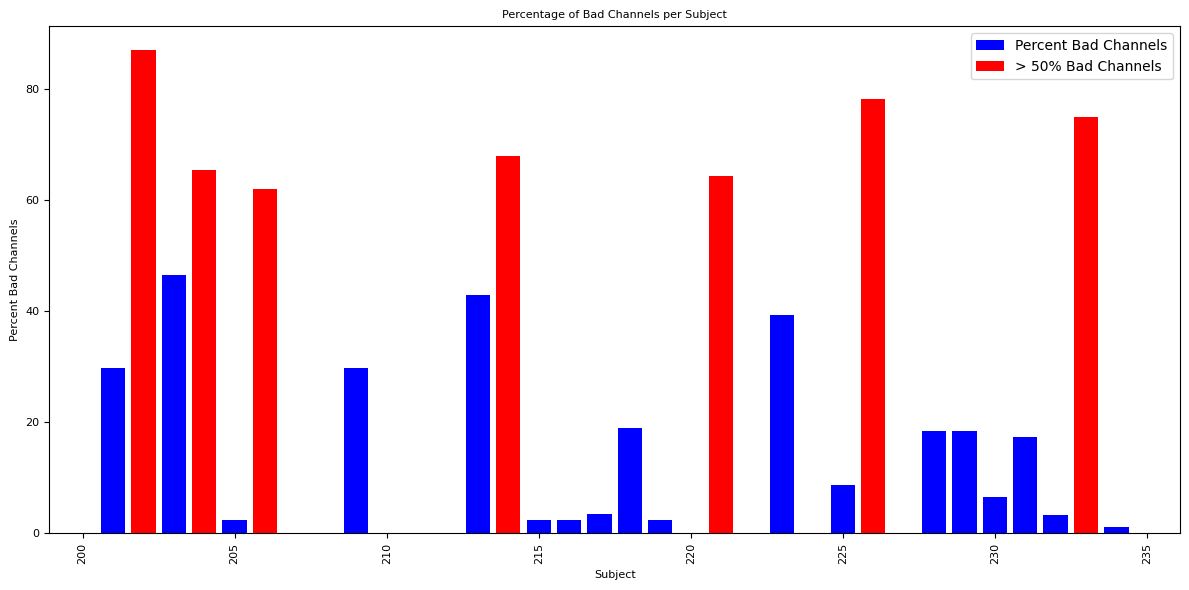

In [18]:
# Remove subjects with >50% bad channels; SKIP

bad_channels_df = pd.read_csv(bad_channels_filename)
bad_channels_df['Percent Bad'] = bad_channels_df['Percent Bad'].str.rstrip('%').astype(float)
average_bad_channels = bad_channels_df.groupby('Subject')['Percent Bad'].mean()

# Find subjects with more than 30% bad channels
bad_subjects = average_bad_channels[average_bad_channels > 50].index.tolist()
print("Subjects with more than 50% bad channels:", bad_subjects)

# Initialize counters for each group
removed_trained = 0
removed_control = 0
remaining_trained = 0
remaining_control = 0

# Count and remove the subjects
for subject in bad_subjects:
    subject_int = int(subject) 
    if subject_int in subject_to_group:
        if subject_to_group[subject_int] == "trained":
            removed_trained += 1
        elif subject_to_group[subject_int] == "control":
            removed_control += 1
        subject_to_group.pop(subject_int, None)

# Update the subjects list after counting the removed subjects
subjects = [subject for subject in subjects if subject not in bad_subjects]
for group in subject_to_group.values():
    if group == "trained":
        remaining_trained += 1
    elif group == "control":
        remaining_control += 1

# Output the results
print(" ")
print(f'Removed {removed_trained} trained subjects.')
print(f'Removed {removed_control} control subjects.')
print(" ")
print(f'Remaining trained subjects: {remaining_trained}')
print(f'Remaining control subjects: {remaining_control}')


# Load the bad channels data
bad_channels_df = pd.read_csv(bad_channels_filename)

# Ensure 'Percent Bad' is treated as a string, strip '%', and convert to float
bad_channels_df['Percent Bad'] = bad_channels_df['Percent Bad'].astype(str).str.rstrip('%').astype(float)

# Sort the DataFrame by 'Percent Bad' in ascending order
bad_channels_df_sorted = bad_channels_df.sort_values(by='Percent Bad')

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(bad_channels_df_sorted['Subject'], bad_channels_df_sorted['Percent Bad'], color='blue', label='Percent Bad Channels')

# Highlight subjects with more than 50% bad channels
plt.bar(bad_channels_df_sorted[bad_channels_df_sorted['Percent Bad'] > 50]['Subject'],
        bad_channels_df_sorted[bad_channels_df_sorted['Percent Bad'] > 50]['Percent Bad'],
        color='red', label='> 50% Bad Channels')

plt.xlabel('Subject')
plt.ylabel('Percent Bad Channels')
plt.title('Percentage of Bad Channels per Subject')
plt.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
# Clean events and make design matrix

def make_design(raw_h_long, design, subject=None, run=None, day=None, group=None):
    annotations_to_remove = raw_h_long.annotations.description == '255.0'
    raw_h_long.annotations.delete(annotations_to_remove)
    events, _ = mne.events_from_annotations(raw_h_long)
    
    # Fix mis-codings
    rows_to_remove = events[:, -1] == 1
    events = events[~rows_to_remove]
    if len(events) == 101:
        events = events[1:]

    n_times = len(raw_h_long.times)
    stim = np.zeros((n_times, 4))
    events[:, 2] -= 1
    assert len(events) == 100, len(events)
    want = [0] + [25] * 4
    count = np.bincount(events[:, 2])
    assert np.array_equal(count, want), count
    assert events.shape == (100, 3), events.shape

    if design == 'block':
        events = events[0::5]
        duration = 20.
        assert np.array_equal(np.bincount(events[:, 2]), [0] + [5] * 4)
    else:
#        assert design == 'event'
        assert len(events) == 100
        duration = 1.8
        assert events.shape == (100, 3)
        events_r = events[:, 2].reshape(20, 5)
        assert (events_r == events_r[:, :1]).all()
        del events_r
        
    idx = (events[:, [0, 2]] - [0, 1]).T
    assert np.in1d(idx[1], np.arange(len(conditions))).all()
    stim[tuple(idx)] = 1
    
    n_block = int(np.ceil(duration * sfreq))
    stim = signal.fftconvolve(stim, np.ones((n_block, 1)), axes=0)[:n_times]
    dm_events = pd.DataFrame({
        'trial_type': [conditions[ii] for ii in idx[1]],
        'onset': idx[0] / raw_h_long.info['sfreq'],
        'duration': n_block / raw_h_long.info['sfreq']})
    dm = make_first_level_design_matrix(
        raw_h_long.times, dm_events, hrf_model='glover',
        drift_model='polynomial', drift_order=0)
        
    return stim, dm, events


Opening raw data file ../../processed/223_1_001_long_hbo_bad50_raw.fif...
    Range : 0 ... 3937 =      0.000 ...   818.896 secs
Ready.
Reading 0 ... 3937  =      0.000 ...   818.896 secs...
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']


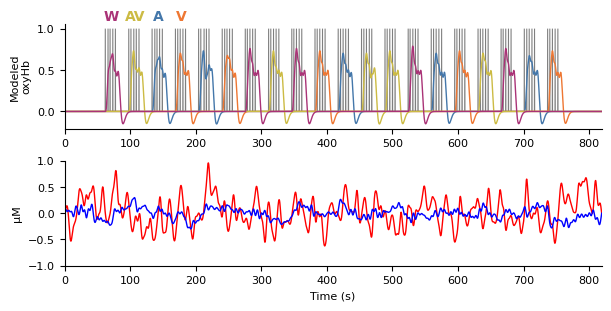

In [20]:
# Change the subject, day, and run to plot different waveforms; SKIP

plot_subject = '223'
plot_day = 1
plot_run = 1

fname2 = op.join(proc_path, f'{plot_subject}_{plot_day}_{plot_run:03d}_long_hbo_{output_suffix}_raw.fif')
use = mne.io.read_raw_fif(fname2, preload=True)
events, _ = mne.events_from_annotations(use)
ch_names = [ch_name.rstrip(' hbo') for ch_name in use.ch_names]
info = use.info

fig, axes = plt.subplots(2, 1, figsize=(6., 3), constrained_layout=True)
ax = axes[0]
raw_h = use
stim, dm, _ = make_design(raw_h, design)

colors = dict(
    A='#4477AA',  # blue
    AV='#CCBB44',  # yellow
    V='#EE7733',  # orange
    W='#AA3377',  # purple
)

for ci, condition in enumerate(conditions):
    color = colors[condition]
    ax.fill_between(
        raw_h.times, stim[:, ci], 0, edgecolor='none', facecolor='k',
        alpha=0.5)
    model = dm[conditions[ci]].to_numpy()
    ax.plot(raw_h.times, model, ls='-', lw=1, color=color)
    x = raw_h.times[np.where(model > 0)[0][0]]
    ax.text(
        x + 10, 1.1, condition, color=color, fontweight='bold', ha='center')
ax.set(ylabel='Modeled\noxyHb', xlabel='', xlim=raw_h.times[[0, -1]])

# HbO/HbR
ax = axes[1]
picks = [pi for pi, ch_name in enumerate(raw_h.ch_names)
         if 'S7_D19' in ch_name]
colors = dict(hbo='r', hbr='b')
ylim = np.array([-1, 1])
for pi, pick in enumerate(picks):
    color = colors[raw_h.ch_names[pick][-3:]]
    data = raw_h.get_data(pick)[0] * 1e6
    val = np.ptp(data)
    assert val > 0.01
    ax.plot(raw_h.times, data, color=color, lw=1.)
ax.set(ylim=ylim, xlabel='Time (s)', ylabel='μM',
       xlim=raw_h.times[[0, -1]])
for ax in axes:
    for key in ('top', 'right'):
        ax.spines[key].set_visible(False)
plt.savefig(op.join(results_path, f'figure_1_{output_suffix}.png'))


In [21]:
# Run GLM analysis and epoching

subj_cha_list = []
for subject in subjects:
    group = subject_to_group.get(int(subject), "unknown")
    for day in days:
        for run in runs:
            fname_long = op.join(proc_path, f'{subject}_{day}_{run:03d}_long_hbo_{output_suffix}_raw.fif')
            raw_h_long = mne.io.read_raw_fif(fname_long)
            _, dm, _ = make_design(raw_h_long, design, subject, run, day, group)
            glm_est = mne_nirs.statistics.run_glm(
                raw_h_long, dm, noise_model='ols', n_jobs=n_jobs)
            cha = glm_est.to_dataframe()
            cha['subject'] = subject
            cha['run'] = run
            cha['day'] = day
            cha['group'] = group
            subj_cha_list.append(cha)
            del raw_h_long, dm, glm_est, cha
            gc.collect()  #
        print(f'***Finished processing subject {subject} day {day}.')

df_cha = pd.concat(subj_cha_list, ignore_index=True)
df_cha.reset_index(drop=True, inplace=True)


Opening raw data file ../../processed/201_1_001_long_hbo_bad50_raw.fif...
    Range : 0 ... 3994 =      0.000 ...   830.752 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Opening raw data file ../../processed/201_1_002_long_hbo_bad50_raw.fif...
    Range : 0 ... 3838 =      0.000 ...   798.304 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
***Finished processing subject 201 day 1.
Opening raw data file ../../processed/201_3_001_long_hbo_bad50_raw.fif...
    Range : 0 ... 3945 =      0.000 ...   820.560 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Opening raw data file ../../processed/201_3_002_long_hbo_bad50_raw.fif...
    Range : 0 ... 3945 =      0.000 ...   820.560 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
***Finished processing subject 201 day 3.
Opening raw data file ../../processed/202_1_001_long_hbo_bad50_raw.fif...
    Range : 0 ... 3946 =      

In [22]:
# Block averages

event_id = {condition: ci for ci, condition in enumerate(conditions, 1)}
evokeds = {condition: dict() for condition in conditions}
for day in days:
    for subject in subjects:
        fname = op.join(proc_path, f'{subject}_{day}_{output_suffix}-ave.fif')
        tmin, tmax = -2, 38
        baseline = (None, 0)
        t0 = time.time()
        print(f'Creating block average for {subject} day {day}... ', end='')
        raws = list()
        events = list()
        for run in runs:
            fname2 = op.join(proc_path, f'{subject}_{day}_{run:03d}_long_hbo_{output_suffix}_raw.fif')
            raw_h = mne.io.read_raw_fif(fname2)
            events.append(make_design(raw_h, None, 'block', subject, run)[2])
            raws.append(raw_h)
        bads = sorted(set(sum((r.info['bads'] for r in raws), [])))
        for r in raws:
            r.info['bads'] = bads
        raw_h, events = mne.concatenate_raws(raws, events_list=events)
        epochs = mne.Epochs(raw_h, events, event_id, tmin=tmin, tmax=tmax,
                            baseline=baseline)
        this_ev = [epochs[condition].average() for condition in conditions]
        assert all(ev.nave > 0 for ev in this_ev)
        mne.write_evokeds(fname, this_ev, overwrite=True)
        print(f'{time.time() - t0:0.1f} sec')
        for condition in conditions:
            evokeds[condition][subject] = mne.read_evokeds(fname, condition)
        print(f'Done for {group} {subject} day {day} run {run:03d}... ', end='')
        del raws, events, raw_h, epochs, this_ev
        gc.collect()  #

# Mark bad channels
bad = dict()
bb = dict()

for day in days:
    for subject in subjects:
        for run in runs:
            fname2 = op.join(proc_path, f'{subject}_{day}_{run:03d}_long_hbo_{output_suffix}_raw.fif')
            this_info = mne.io.read_info(fname2)
            bad_channels = [idx - 1 for idx in sorted(
                this_info['ch_names'].index(bad) + 1 for bad in this_info['bads'])]
            valid_indices = np.arange(len(use.ch_names))
            bb = [b for b in bad_channels if b in valid_indices]
            bad[(subject, run, day)] = bb
        assert np.in1d(bad[(subject, run, day)], np.arange(len(use.ch_names))).all()

bad_combo = dict()
for day in days:
    for (subject, run, day), bb in bad.items():
        bad_combo[subject] = sorted(set(bad_combo.get(subject, [])) | set(bb))
bad = bad_combo

start = len(df_cha)
n_drop = 0
for day in days:
    for (subject, run, day), bb in bad.items():
        if not len(bb):
            continue
        drop_names = [use.ch_names[b] for b in bb]
        is_subject = (df_cha['subject'] == subject)
        is_day = (df_cha['day'] == day)
        drop = df_cha.index[
            is_subject &
            is_day &
            np.in1d(df_cha['ch_name'], drop_names)]
        n_drop += len(drop)
        if len(drop):
            print(f'Dropping {len(drop)} for {subject} day {day}')
            df_cha.drop(drop, inplace=True)
end = len(df_cha)
assert n_drop == start - end, (n_drop, start - end)

# Combine runs by averaging
sorts = ['subject', 'ch_name', 'Chroma', 'Condition', 'group', 'day', 'run']
df_cha.sort_values(sorts, inplace=True)
theta = np.array(df_cha['theta']).reshape(-1, len(runs)).mean(-1)
df_cha.drop(
    [col for col in df_cha.columns if col not in sorts[:-1]], axis='columns',
    inplace=True)
df_cha.reset_index(drop=True, inplace=True)
df_cha = df_cha[::len(runs)]
df_cha.reset_index(drop=True, inplace=True)
df_cha['theta'] = theta

Creating block average for 201 day 1... Opening raw data file ../../processed/201_1_001_long_hbo_bad50_raw.fif...
    Range : 0 ... 3994 =      0.000 ...   830.752 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Opening raw data file ../../processed/201_1_002_long_hbo_bad50_raw.fif...
    Range : 0 ... 3838 =      0.000 ...   798.304 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Not setting metadata
200 matching events found
Setting baseline interval to [-2.0800001110839905, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
4.4 sec
Reading /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_bad50-ave.fif ...
    Found the data of interest:
        t =   -2080.00 ...   38064.00 ms (A)
        0 CTF compensation matrices available
        nave = 50 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded 

In [23]:
# Calculate HbDiff

# Load the data
df_cha_nolabels = df_cha.copy()
df_cha_nolabels['ch_name'] = df_cha_nolabels['ch_name'].str[:-4]

# Separate HbO and HbR
df_hbo = df_cha_nolabels[df_cha_nolabels['Chroma'].str.endswith('hbo')].set_index(['subject', 'Condition', 'group', 'day', 'ch_name']).sort_index()
df_hbr = df_cha_nolabels[df_cha_nolabels['Chroma'].str.endswith('hbr')].set_index(['subject', 'Condition', 'group', 'day', 'ch_name']).sort_index()

# Compute the difference
df_cha_diff_list = []
for ch_name in df_hbo.index.get_level_values('ch_name').unique():
    # Get aligned indices
    df_hbo_ch = df_hbo.loc[(slice(None), slice(None), slice(None), slice(None), ch_name), :].sort_index()
    df_hbr_ch = df_hbr.loc[(slice(None), slice(None), slice(None), slice(None), ch_name), :].sort_index()
    
    # Ensure df_hbo_ch and df_hbr_ch have the same length
    common_index = df_hbo_ch.index.intersection(df_hbr_ch.index)
    df_hbo_ch = df_hbo_ch.loc[common_index]
    df_hbr_ch = df_hbr_ch.loc[common_index]
    
    # Calculate the difference
    df_diff = df_hbo_ch[['theta']].sub(df_hbr_ch[['theta']])
    
    # Align df_cha_ch with df_diff
    df_cha_ch = df_hbo_ch.reset_index()
    df_cha_ch['theta'] = df_diff.values
    df_cha_ch['Chroma'] = 'hbdiff'
    df_cha_ch['ch_name'] = df_cha_ch['ch_name'] + ' hbdiff'
    
    if not df_cha_ch.empty:
        df_cha_diff_list.append(df_cha_ch)

df_cha_diff_concat = pd.concat(df_cha_diff_list, ignore_index=True)

# Concatenate original df_cha with df_cha_diff_concat
df_final = pd.concat([df_cha, df_cha_diff_concat], ignore_index=True)
df_final.to_csv(op.join(results_path, f'df_combined_final_cha_{output_suffix}.csv'), index=False)


Run correlational analyses below.

In [1]:
import os.path as op
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings
warnings.filterwarnings("ignore", category=ValueWarning) # type: ignore
warnings.filterwarnings("ignore", category=UserWarning) # type: ignore
from scipy.stats import ttest_rel, zscore
import mne 
import numpy as np
import gc

# Load the datasets
behavior_file = '../../behavior_diff_data2.csv'
behavior_df = pd.read_csv(behavior_file)
behavior_df['subject'] = behavior_df['subject'].astype(str)

output_suffix = 'final'

df_final = pd.read_csv(op.join(f'../../results/df_combined_final_cha_{output_suffix}.csv'))
theta_df = df_final.copy()
theta_df['subject'] = theta_df['subject'].astype(str)
results_path = '../../results/correlations'

# Get the unique conditions
conditions = ['A', 'AV', 'V']
response_vars = ['AO_WR', 'AV_WR', 'TBW']
chromas = ['hbo', 'hbr', 'hbdiff']
days = [1, 3]

Opening raw data file ../../processed/205_1_001_long_hbo_final_raw.fif...
    Range : 0 ... 4171 =      0.000 ...   867.568 secs
Ready.
Reading 0 ... 4171  =      0.000 ...   867.568 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
      Significant Channel: S15_D14 hbo, Corrected p-value: 0.04145650583661752, R^2: 0.7367077245612972


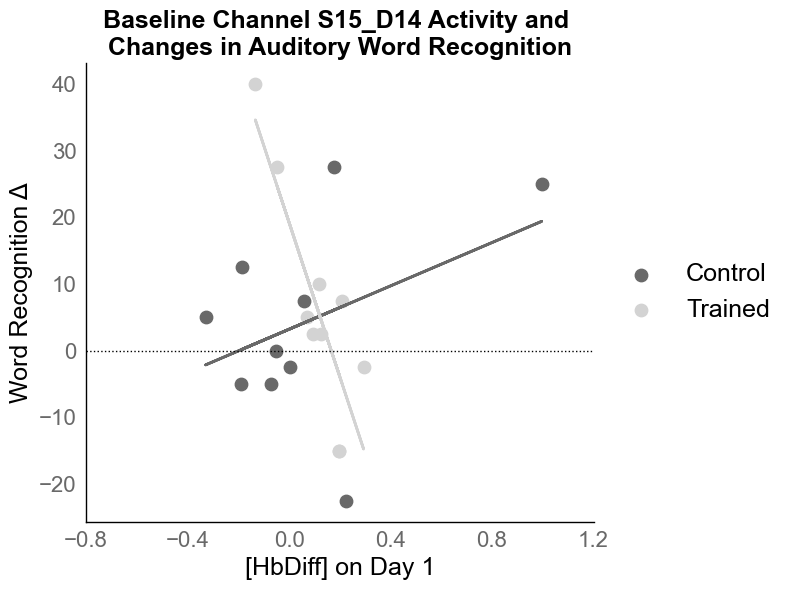

      Significant Channel: S19_D4 hbo, Corrected p-value: 0.005899332489432629, R^2: 0.8657075815562162


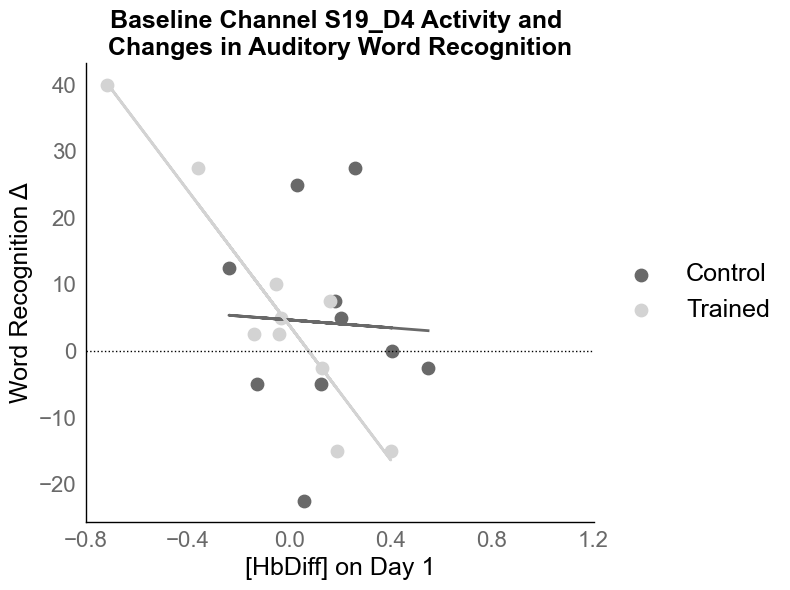

      Significant Channel: S21_D10 hbo, Corrected p-value: 0.005899332489432629, R^2: 0.851818535397406


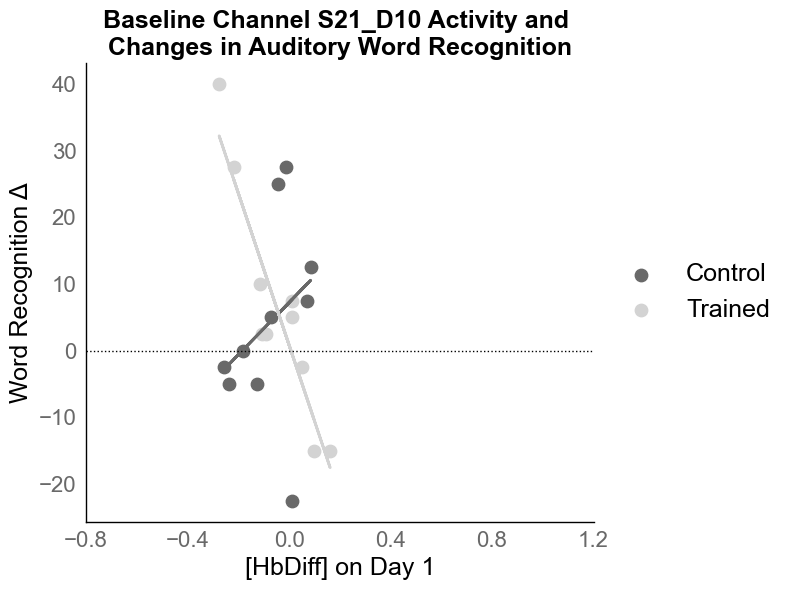

In [39]:
# Baseline theta vs. WR changes
#output_suffix = theta_vs_behavior

# Set your conditions, response variables, and chromas
conditions = ['AV']
response_vars = ['AO_WR']
chromas = ['hbdiff']
days = [1]
proc_path = '../../processed'
subjects_dir = '../../subjects'
output_suffix = 'baseline_WR_correlation'

# Load the MNE raw data
fname = op.join(proc_path, '205_1_001_long_hbo_final_raw.fif')
use = mne.io.read_raw_fif(fname, preload=True)

# Prepare channels for consistency
new_ch_names = {}
seen_names = set()
for ch_name in use.info['ch_names']:
    new_name = ch_name.split(' ')[0]  # Clean channel names
    if new_name not in seen_names:
        new_ch_names[ch_name] = new_name
        seen_names.add(new_name)

use.rename_channels(new_ch_names)
use.pick_channels(list(new_ch_names.values()))  # Pick only renamed channels

theta_df['ch_name'] = theta_df['ch_name'].str.split(' ').str[0]  # Clean theta_df channels

def perform_analysis(group, output_suffix, theta_df, behavior_df, days, chromas, conditions, response_vars):
    # Initialize a list to store significant models
    significant_models = []
    z_scores_dict = {}  # Dictionary to store z-scores by day, chroma, and channel

    # Initialize a dictionary to store p-values and model data by condition, response variable, chroma, and day
    all_p_values = {condition: {response_var: {chroma: {day: [] for day in days} for chroma in chromas} for response_var in response_vars} for condition in conditions}
    all_model_data = {condition: {response_var: {chroma: {day: [] for day in days} for chroma in chromas} for response_var in response_vars} for condition in conditions}

    for day in days:
        theta_df_filtered = theta_df[theta_df['day'] == day].copy()

        for chroma in chromas:
            theta_dataset = theta_df_filtered[theta_df_filtered['Chroma'] == chroma].copy()
            for condition in conditions:
                for response_var in response_vars:
                    theta_df_condition = theta_dataset[theta_dataset['Condition'] == condition]

                    # Pivot theta_df to have channel names as columns
                    theta_pivot = theta_df_condition.pivot_table(index=['subject', 'group', 'Condition'], columns='ch_name', values='theta').reset_index()
                    theta_pivot['subject'] = theta_pivot['subject'].astype(str)

                    # Merge theta_df with behavior data
                    merged_df = pd.merge(theta_pivot, behavior_df[['subject', 'group', 'TBW', 'AO_WR', 'AV_WR', 'VO_WR', 'age', 'AO_WR_1', 'AV_WR_1', 'VO_WR_1', 'TBW_1']], on=['subject', 'group'])

                    channels = theta_df_condition['ch_name'].unique()
                    p_values = []  # Store p-values for FDR correction
                    model_data = []  # Store model data for each channel

                    for channel in channels:
                        df = merged_df[[channel, response_var, 'group']].dropna()
                        if df.empty:
                            continue  # Skip this channel if there is no data

                        # Fit the model (no " hbo" yet)
                        model = smf.ols(f"{response_var} ~ {channel}", df[df['group'] == group]).fit()
                        r_sq = model.rsquared
                        p_value_channel = model.pvalues[channel]  # p-value for the channel

                        p_values.append(p_value_channel)
                        model_data.append((channel, model, r_sq, df))

                    if p_values:
                        rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

                        # Store z-scores for significant models after FDR correction
                        for i, (channel, model, r_sq, df) in enumerate(model_data):
                            if p_values_corrected[i] < 0.05:  # Significant after FDR
                                channel_hbo = channel + ' hbo'
                                print(f"      Significant Channel: {channel_hbo}, Corrected p-value: {p_values_corrected[i]}, R^2: {r_sq}")
                                z_scores = zscore(df[channel])  # Compute z-scores

                                # Store the z-scores in the dictionary
                                z_scores_dict[(day, chroma, condition, channel_hbo)] = z_scores

                                # Log the significant model
                                significant_models.append({
                                    'day': day, 'chroma': chroma, 'condition': condition, 'channel': channel_hbo,
                                    'r_squared': r_sq, 'p_value': p_values[i], 'p_value_corrected': p_values_corrected[i],
                                    'z_scores': z_scores
                                })

                                # Plot the significant results
                                import matplotlib as mpl
                                mpl.rcParams['font.family'] = 'Arial'
                                plt.figure(figsize=(8, 6))

                                # Scatter plot and regression line for each group
                                for grp, color, linestyle in [('control', 'dimgray', '-'), ('trained', 'lightgray', '-')]:
                                    grp_df = df[df['group'] == grp]
                                    if not grp_df.empty:
                                        grp_model = smf.ols(f"{response_var} ~ {channel}", grp_df).fit()
                                        # Scatter plot
                                        plt.scatter(grp_df[channel]*1e6, grp_df[response_var], label=grp.capitalize(), color=color, s=80)
                                        # Regression line
                                        plt.plot(grp_df[channel]*1e6, grp_model.predict(grp_df), color=color, linestyle=linestyle, linewidth=2)

                                # Customize axes and plot aesthetics
                                plt.gca().spines['top'].set_visible(False)
                                plt.gca().spines['right'].set_visible(False)
                                plt.gca().spines['left'].set_linewidth(1)
                                plt.gca().spines['bottom'].set_linewidth(1)
                                plt.axhline(0, color='black', linestyle=':', linewidth=1)  # Dotted line at y=0
                                plt.xlabel(f'[HbDiff] on Day 1', fontsize=18, color='black')
                                plt.ylabel('Word Recognition Δ', fontsize=18, color='black')
                                plt.title(f'Baseline Channel {channel} Activity and \nChanges in Auditory Word Recognition', fontsize=18, color='black', fontweight='bold')
                                plt.xlim(-0.8, 1.1)
                                plt.xticks(np.arange(-0.8, 1.3, 0.4), fontsize=16, color='dimgray')
                                plt.yticks(fontsize=16, color='dimgray')
                                plt.tick_params(axis='x', which='both', bottom=False, top=False)
                                plt.tick_params(axis='y', which='both', left=False, right=False)
                                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=18)

                                plt.tight_layout()
                                plt.show()

    return significant_models, z_scores_dict




# Perform analysis for the trained group and control group
significant_models, z_scores_dict = perform_analysis('trained', output_suffix, theta_df, behavior_df, days, chromas, conditions, response_vars)
significant_models, z_scores_dict = perform_analysis('control', output_suffix, theta_df, behavior_df, days, chromas, conditions, response_vars)



In [ ]:
# Changes in theta vs. WR changes

conditions = ['A', 'AV', 'V']
response_vars = ['AO_WR']
chromas = ['hbdiff']

# Load the datasets
theta_df_filtered = theta_df.pivot_table(index=['subject', 'group', 'Condition', 'Chroma', 'ch_name'], columns='day', values='theta').reset_index()
theta_df_filtered['theta_diff'] = theta_df_filtered[3] - theta_df_filtered[1]

def perform_analysis(group, output_suffix):
    # Initialize a list to store significant models
    significant_models = []
    all_p_values = {condition: {response_var: {chroma: [] for chroma in chromas} for response_var in response_vars} for condition in conditions}
    all_model_data = {condition: {response_var: {chroma: [] for chroma in chromas} for response_var in response_vars} for condition in conditions}
    for chroma in chromas:
        # Filter theta_df for the specific chroma
        theta_dataset = theta_df_filtered[theta_df_filtered['Chroma'] == chroma].copy()
        theta_dataset['ch_name'] = theta_dataset['ch_name'].str.split(' ').str[0]
        # Collect all p-values and model data for each response variable and condition
        for condition in conditions:
            for response_var in response_vars:
                # Filter the dataset for the current condition
                theta_df_condition = theta_dataset[theta_dataset['Condition'] == condition]
                
                
                # Pivot the theta_df to have channel names as columns
                theta_pivot = theta_df_condition.pivot_table(index=['subject', 'group', 'Condition'], columns='ch_name', values='theta_diff').reset_index()
                theta_pivot['subject'] = theta_pivot['subject'].astype(str)  # Ensure subject is string

                # Merge the datasets based on 'subject' and 'group'
                merged_df = pd.merge(theta_pivot, behavior_df[['subject', 'group', 'TBW', 'AO_WR', 'AV_WR', 'VO_WR']], on=['subject', 'group'])
                channels = theta_df_condition['ch_name'].unique()  # list of all channel names
                for channel in channels:
                    df = merged_df[[channel, response_var, 'group']].dropna()  # drop rows with missing values
                    if df.empty:
                        continue  # Skip this channel if there is no data
                    model = smf.ols(f"{response_var} ~ {channel}", df[df['group'] == group]).fit()
                    r_sq = model.rsquared
                    p_value_channel = model.pvalues[channel]  # p-value for the channel
                    all_p_values[condition][response_var][chroma].append(p_value_channel)
                    all_model_data[condition][response_var][chroma].append((condition, channel, response_var, model, r_sq, p_value_channel, df, chroma))

                p_values = all_p_values[condition][response_var][chroma]
                model_data = all_model_data[condition][response_var][chroma]
                
                if p_values:
                    # Apply FDR correction
                    rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
                    
                    # Filter results based on FDR corrected p-values
                    for (condition, channel, response_var, model, r_sq, p_value, df, chroma), p_val_corr, reject in zip(model_data, p_values_corrected, rejected):
                        if p_value < 0.05:
                            print(f"Group: {group}, Chroma: {chroma}, Condition: {condition}, Channel: {channel}, Outcome: {response_var}\n   R-squared: {r_sq}, p-value: {p_value}, corrected p-value: {p_val_corr}\n")
                            significant_models.append({
                                'Condition': condition,
                                'Channel': channel,
                                'Response Variable': response_var,
                                'R-squared': r_sq,
                                'P-value': p_value,
                                'P-value Corrected': p_val_corr,
                                'Model Summary': model.summary().as_text(),
                                'Chroma': chroma,
                            })
                            # Plot the significant results
                            plt.figure(figsize=(8, 6))

                            # Plot trained data
                            trained_df = df[df['group'] == 'trained']
                            if not trained_df.empty:
                                trained_model = smf.ols(f"{response_var} ~ {channel}", trained_df).fit()
                                sns.scatterplot(x=trained_df[channel], y=trained_df[response_var], label='Trained', color='#92b6f0', s=100)
                                sns.lineplot(x=trained_df[channel], y=trained_model.predict(trained_df), color='#92b6f0', linewidth=2)

                            # Plot control data
                            control_df = df[df['group'] == 'control']
                            if not control_df.empty:
                                control_model = smf.ols(f"{response_var} ~ {channel}", control_df).fit()
                                sns.scatterplot(x=control_df[channel], y=control_df[response_var], label='Control', color='gray', s=100)
                                sns.lineplot(x=control_df[channel], y=control_model.predict(control_df), color='gray', linewidth=2)
                            
                            xlabel = f'{chroma.upper()} Change (Day 3 - Day 1) on {channel}'
                            ylabel = ('Change in Auditory Word Recognition' if response_var == 'AO_WR' else
                                    'Change in Audiovisual Word Recognition' if response_var == 'AV_WR' else
                                    'Change in Visual Word Recognition' if response_var == 'VO_WR' else
                                    f'Change in {response_var}')
                            plt.legend(loc='upper right') 
                            plt.xlabel(xlabel, fontsize=24)
                            plt.ylabel(ylabel, fontsize=24)
                            plt.title(f'{ylabel} vs.\nCortical Response to {condition} Speech ({channel})', fontsize=16)
                            plt.savefig(op.join(results_path, f'{output_suffix}__{group}_{chroma}_{condition}_{response_var}_{channel}_plot.png'))
                            plt.close()

    if significant_models:
        significant_models_df = pd.DataFrame(significant_models).sort_values(by='R-squared', ascending=False)
        csv_file = op.join(results_path, f'{output_suffix}_{group}_models.csv')
        if not op.isfile(csv_file):
            significant_models_df.to_csv(csv_file, index=False, mode='w')
        else:
            significant_models_df.to_csv(csv_file, index=False, mode='a', header=False)
    else:
        print(f'No significant models found for {group} group')


# Perform analysis for the trained group
perform_analysis('trained', output_suffix)

# Perform analysis for the control group
perform_analysis('control', output_suffix)



Starting analysis for condition: AV, chroma: hbdiff, group: trained

Channel: S21_D10, AV, chroma: hbdiff, group: trained
   p-value: 0.001929446864216732, corrected p-value: 0.0028941702963250983, R-squared: 0.7193256917666179



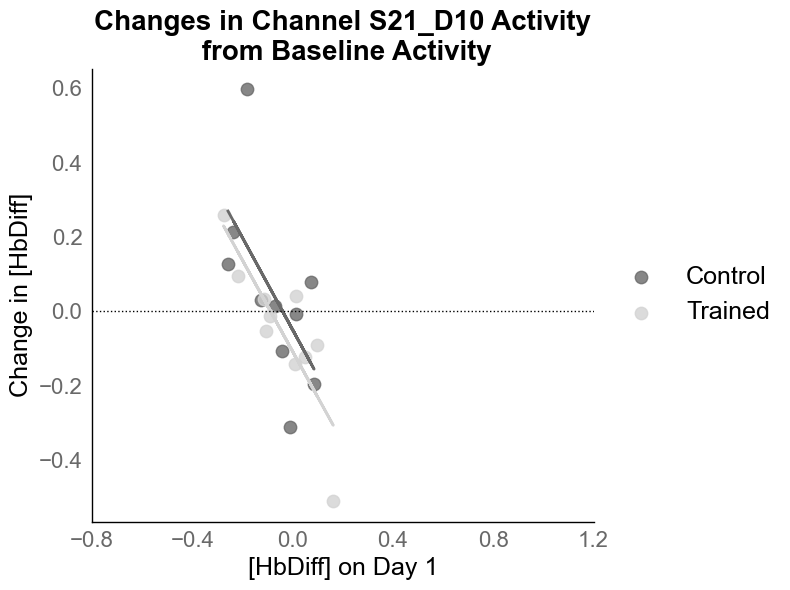

Channel: S19_D4, AV, chroma: hbdiff, group: trained
   p-value: 0.0007011512655170448, corrected p-value: 0.0021034537965511344, R-squared: 0.780378533842912



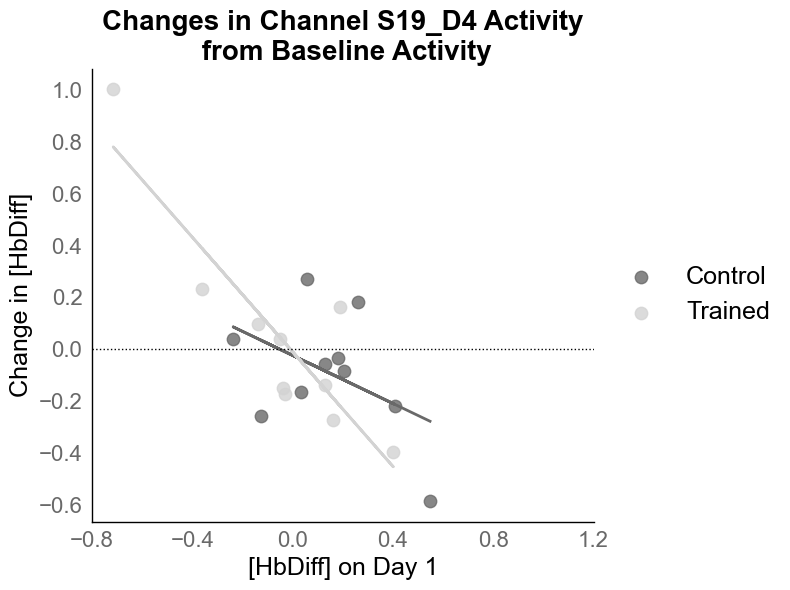

Channel: S15_D14, AV, chroma: hbdiff, group: trained
   p-value: 0.02119790624292061, corrected p-value: 0.02119790624292061, R-squared: 0.505300369006247



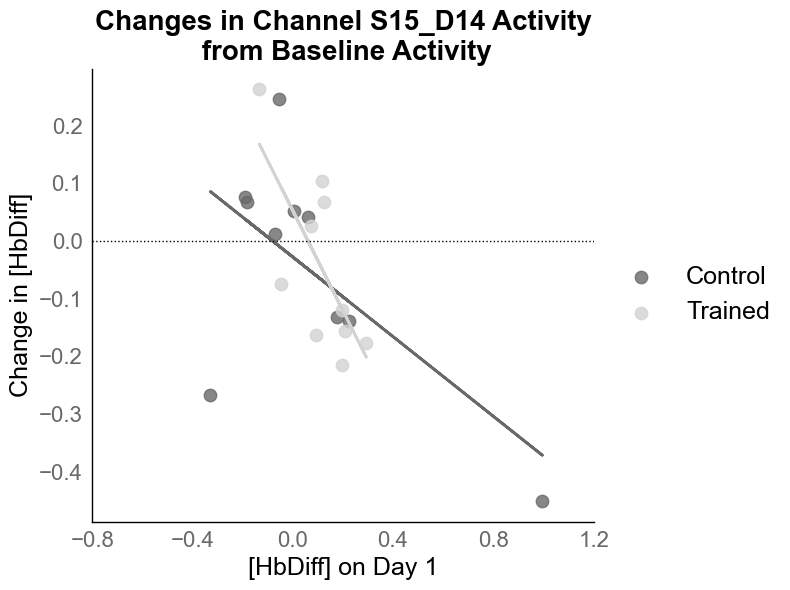


3 out of 3 channels were significantly correlated for group trained.


In [47]:
# Run same analysis for baseline theta vs. change in theta values; SKIP

# Pivot table to get both Day 1 theta and theta_diff (Day 3 - Day 1)
theta_df_filtered = theta_df.pivot_table(index=['subject', 'group', 'Condition', 'Chroma', 'ch_name'], columns='day', values='theta').reset_index()
theta_df_filtered['theta_diff'] = theta_df_filtered[3] - theta_df_filtered[1]  # Calculate theta_diff
theta_df_filtered['theta_baseline'] = theta_df_filtered[1]  # Baseline theta (Day 1)

# Specify the channels you want to analyze
chromas = ['hbdiff']
conditions = ['AV']
response_vars = ['AO_WR']
channels_to_analyze = ['S21_D10', 'S19_D4', 'S15_D14']
output_suffix = 'theta_diff_vs_baseline'

def perform_analysis(group, output_suffix, channels):
    # Initialize a list to store significant models
    theta_df_filtered['ch_name'] = theta_df_filtered['ch_name'].str.split(' ').str[0]
    significant_models = []
    
    # Reset counters here
    total_channels_analyzed = 0
    significant_channels_count = 0
    
    for chroma in chromas:
        all_p_values = []
        model_data = []

        for condition in conditions:
            print(f"\nStarting analysis for condition: {condition}, chroma: {chroma}, group: {group}\n")
            # Filter the dataset for the current condition and chroma
            theta_df_condition = theta_df_filtered[(theta_df_filtered['Chroma'] == chroma) & (theta_df_filtered['Condition'] == condition)]
            
            # Filter the dataset to include only the specified channels
            theta_df_condition = theta_df_condition[theta_df_condition['ch_name'].isin(channels)]

            # Pivot the theta_df to have channel names as columns, keeping 'group' in the index
            theta_pivot = theta_df_condition.pivot_table(index=['subject', 'group'], columns='ch_name', values=['theta_diff', 'theta_baseline'])
            theta_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in theta_pivot.columns.values]  # Flatten the MultiIndex
            
            # Reset the index to make 'group' a column again
            theta_pivot.reset_index(inplace=True)
            
            # Iterate over each channel
            for channel in channels:                
                # Ensure both baseline and diff values are available
                baseline_column = f'theta_baseline_{channel}'
                diff_column = f'theta_diff_{channel}'
                
                if baseline_column in theta_pivot.columns and diff_column in theta_pivot.columns:
                    df = theta_pivot[[diff_column, baseline_column, 'group']].dropna()  # drop rows with missing values
                    if df.empty:
                        print(f"  No data available for channel: {channel}, skipping.")
                        continue  # Skip this channel if there is no data

                    total_channels_analyzed += 1  # Increment the total channels analyzed counter

                    # Regression model: theta_diff ~ theta_baseline
                    model = smf.ols(f"{diff_column} ~ {baseline_column}", df[df['group'] == group]).fit()
                    r_sq = model.rsquared
                    p_value_channel = model.pvalues[baseline_column]  # p-value for the channel

                    # Collect p-values and models for FDR correction
                    all_p_values.append(p_value_channel)
                    model_data.append((condition, channel, r_sq, p_value_channel, model, chroma, baseline_column, diff_column, df))
        
        # Apply FDR correction
        rejected, p_values_corrected, _, _ = multipletests(all_p_values, alpha=0.05, method='fdr_bh')

        for i, (condition, channel, r_sq, p_value, model, chroma, baseline_column, diff_column, df) in enumerate(model_data):
            if p_values_corrected[i] < 0.05:
                print(f"Channel: {channel}, {condition}, chroma: {chroma}, group: {group}")
                print(f"   p-value: {p_value}, corrected p-value: {p_values_corrected[i]}, R-squared: {r_sq}\n")
                significant_channels_count += 1  # Increment the significant channels counter
                significant_models.append({
                    'Condition': condition,
                    'Channel': channel,
                    'R-squared': r_sq,
                    'P-value': p_value,
                    'P-value Corrected': p_values_corrected[i],
                    'Model Summary': model.summary().as_text(),
                    'Chroma': chroma,
                    'Group': group,
                })

                # Plot the significant results with new formatting
                import matplotlib as mpl
                mpl.rcParams['font.family'] = 'Arial'
                plt.figure(figsize=(8, 6))

                # Plot control data
                control_df = df[df['group'] == 'control']
                if not control_df.empty:
                    control_model = smf.ols(f"{diff_column} ~ {baseline_column}", control_df).fit()
                    plt.scatter(control_df[baseline_column] * 1e6, control_df[diff_column] * 1e6, label='Control', color='dimgray', s=80, alpha=0.8)
                    plt.plot(control_df[baseline_column] * 1e6, control_model.predict(control_df) * 1e6, color='dimgray', linestyle='-', linewidth=2)

                # Plot trained data
                trained_df = df[df['group'] == 'trained']
                if not trained_df.empty:
                    trained_model = smf.ols(f"{diff_column} ~ {baseline_column}", trained_df).fit()
                    plt.scatter(trained_df[baseline_column] * 1e6, trained_df[diff_column] * 1e6, label='Trained', color='lightgray', s=80, alpha=0.8)
                    plt.plot(trained_df[baseline_column] * 1e6, trained_model.predict(trained_df) * 1e6, color='lightgray', linestyle='-', linewidth=2)

                # Customize axes and plot aesthetics
                plt.gca().spines['top'].set_visible(False)
                plt.gca().spines['right'].set_visible(False)
                plt.gca().spines['left'].set_linewidth(1)
                plt.gca().spines['bottom'].set_linewidth(1)
                plt.axhline(0, color='black', linestyle=':', linewidth=1)  # Dotted line at y=0
                plt.xlabel(f'[HbDiff] on Day 1', fontsize=18, color='black')
                plt.ylabel(f'Change in [HbDiff]', fontsize=18, color='black')
                plt.title(f'Changes in Channel {channel} Activity\n from Baseline Activity', fontsize=20, color='black', fontweight='bold')
                plt.xlim(-0.8, 1.1)
                plt.xticks(np.arange(-0.8, 1.3, 0.4), fontsize=16, color='dimgray')
                plt.yticks(fontsize=16, color='dimgray')
                plt.tick_params(axis='x', which='both', bottom=False, top=False)
                plt.tick_params(axis='y', which='both', left=False, right=False)

                # Customize legend to be outside the plot area to the right
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=18)

                plt.tight_layout()  # Adjusts subplot params for better fit
                plt.show()

    # Save significant models to CSV
    if significant_models:
        significant_models_df = pd.DataFrame(significant_models).sort_values(by='R-squared', ascending=False)
        csv_file = op.join(results_path, f'{output_suffix}_{group}_models.csv')
        #if not op.isfile(csv_file):
        #    significant_models_df.to_csv(csv_file, index=False, mode='w')
        #else:
        significant_models_df.to_csv(csv_file, index=False, mode='a', header=False)
    else:
        print(f'No significant models found for group {group}')
    
    # Print the counter
    print(f"\n{significant_channels_count} out of {total_channels_analyzed} channels were significantly correlated for group {group}.")

# Perform analysis for the trained group
perform_analysis('trained', output_suffix, channels_to_analyze)


In [ ]:
# Run same analysis for day 1 vs day 3 theta values; SKIP

# Load the datasets
behavior_df = pd.read_csv(behavior_file)
behavior_df['subject'] = behavior_df['subject'].astype(str)

theta_df_filtered = df_final.copy()
theta_df_filtered['subject'] = theta_df_filtered['subject'].astype(str)

# Pivot table to get both Day 1 theta and theta_diff (Day 3 - Day 1)
theta_df_filtered = theta_df_filtered.pivot_table(index=['subject', 'group', 'Condition', 'Chroma', 'ch_name'], columns='day', values='theta').reset_index()
theta_df_filtered['theta_diff'] = theta_df_filtered['3'] - theta_df_filtered['1']  # Calculate theta_diff
theta_df_filtered['theta_baseline'] = theta_df_filtered['1']  # Baseline theta (Day 1)

# Specify the channels you want to analyze
channels_to_analyze = ['S19_D4', 'S19_D6', 'S25_D14', 'S15_D14', 'S21_D10', 'S3_D4', 'S4_D3', 'S8_D18']  # Example channels

# Get the unique conditions
conditions = ['A', 'AV', 'V']
chromas = ['hbo', 'hbr', 'hbdiff']

def perform_analysis(group, output_suffix, channels):
    # Initialize a list to store significant models
    theta_df_filtered['ch_name'] = theta_df_filtered['ch_name'].str.split(' ').str[0]
    significant_models = []
    total_channels_analyzed = 0
    significant_channels_count = 0

    for chroma in chromas:
        all_p_values = []
        model_data = []

        # Filter theta_df for the specific chroma
        theta_dataset = theta_df_filtered[theta_df_filtered['Chroma'] == chroma].copy()
        theta_dataset['ch_name'] = theta_dataset['ch_name'].str.split(' ').str[0]

        # Collect all p-values and model data for each condition
        for condition in conditions:
            print(f"\nStarting analysis for condition: {condition}, chroma: {chroma}, group: {group}\n")
            # Filter the dataset for the current condition
            theta_df_condition = theta_dataset[theta_dataset['Condition'] == condition].copy()
            
            # Filter the dataset to include only the specified channels
            theta_df_condition = theta_df_condition[theta_df_condition['ch_name'].isin(channels)]

            # Pivot the theta_df to have channel names as columns, keeping 'group' in the index
            theta_pivot = theta_df_condition.pivot_table(index=['subject', 'group'], columns='ch_name', values=['1', '3'])  # 1 for Day 1, 3 for Day 3
            theta_pivot.columns = [f'{day}_{ch_name}' for day, ch_name in theta_pivot.columns]  # Simplify the column names
            
            # Reset the index to make 'group' a column again
            theta_pivot.reset_index(inplace=True)
            
            # Iterate over each channel
            for channel in channels:                
                # Ensure both Day 1 and Day 3 values are available
                day1_column = f'1_{channel}'
                day3_column = f'3_{channel}'
                
                if day1_column in theta_pivot.columns and day3_column in theta_pivot.columns:
                    df = theta_pivot[[day1_column, day3_column, 'group']].dropna()  # drop rows with missing values
                    if df.empty:
                        print(f"  No data available for channel: {channel}, skipping.")
                        continue  # Skip this channel if there is no data

                    total_channels_analyzed += 1  # Increment the total channels analyzed counter

                    # Regression model: Day 3 ~ Day 1
                    formula = f'Q("{day3_column}") ~ Q("{day1_column}")'
                    model = smf.ols(formula, df[df['group'] == group]).fit()
                    r_sq = model.rsquared
                    p_value_channel = model.pvalues[f'Q("{day1_column}")']  # p-value for the channel

                    # Collecting all p-values and models
                    all_p_values.append(p_value_channel)
                    model_data.append((condition, channel, r_sq, p_value_channel, model, chroma))

        if all_p_values:
            # Apply FDR correction
            rejected, p_values_corrected, _, _ = multipletests(all_p_values, alpha=0.05, method='fdr_bh')

            # Filter results based on FDR corrected p-values and plot only if significant
            for i, (condition, channel, r_sq, p_value, model, chroma) in enumerate(model_data):
                if p_values_corrected[i] < 0.05:
                    print(f"Channel: {channel}, {condition}, chroma: {chroma}, group: {group}\n   R-squared: {r_sq}, corrected p-value: {p_values_corrected[i]}\n")
                    significant_channels_count += 1  # Increment the significant channels counter
                    significant_models.append({
                        'Condition': condition,
                        'Channel': channel,
                        'R-squared': r_sq,
                        'P-value': p_value,
                        'P-value Corrected': p_values_corrected[i],
                        'Model Summary': model.summary().as_text(),
                        'Chroma': chroma,
                        'Group': group
                    })

                    # Plot the significant results
                    plt.figure(figsize=(8, 6))

                    # Plot trained data
                    trained_df = df[df['group'] == 'trained']
                    if not trained_df.empty:
                        trained_model = smf.ols(formula, trained_df).fit()
                        sns.scatterplot(x=trained_df[day1_column], y=trained_df[day3_column], label='Trained', color='#92b6f0', s=100)
                        sns.lineplot(x=trained_df[day1_column], y=trained_model.predict(trained_df), color='#92b6f0', linewidth=2)

                    # Plot control data
                    control_df = df[df['group'] == 'control']
                    if not control_df.empty:
                        control_model = smf.ols(formula, control_df).fit()
                        sns.scatterplot(x=control_df[day1_column], y=control_df[day3_column], label='Control', color='gray', s=100)
                        sns.lineplot(x=control_df[day1_column], y=control_model.predict(control_df), color='gray', linewidth=2)

                    xlabel = f'{chroma.upper()} (Day 1) on {channel}'
                    ylabel = f'{chroma.upper()} (Day 3)'
                    plt.legend(loc='upper right') 
                    plt.xlabel(xlabel, fontsize=16)
                    plt.ylabel(ylabel, fontsize=16)
                    plt.title(f'{ylabel} vs.\nCortical Response to {condition} Speech ({channel})', fontsize=16)
                    plt.savefig(op.join(results_path, f'{output_suffix}__{group}_{chroma}_{condition}_{channel}_plot.png'))
                    plt.close()

    # Save significant models to CSV
    if significant_models:
        significant_models_df = pd.DataFrame(significant_models).sort_values(by='R-squared', ascending=False)
        csv_file = op.join(results_path, f'{output_suffix}_{group}_models.csv')
        if not op.isfile(csv_file):
            significant_models_df.to_csv(csv_file, index=False, mode='w')
        else:
            significant_models_df.to_csv(csv_file, index=False, mode='a', header=False)
    else:
        print(f'No significant models found for group {group}')
    
    # Print the counter
    print(f"\n{significant_channels_count} out of {total_channels_analyzed} channels were significantly correlated for group {group}.")

# Perform analysis for the trained group
perform_analysis('trained', 'theta_day1_vs_day3', channels_to_analyze)



Code below is still in progress...

Opening raw data file ../../processed/205_1_001_long_hbo_final_raw.fif...
    Range : 0 ... 4171 =      0.000 ...   867.568 secs
Ready.
Reading 0 ... 4171  =      0.000 ...   867.568 secs...


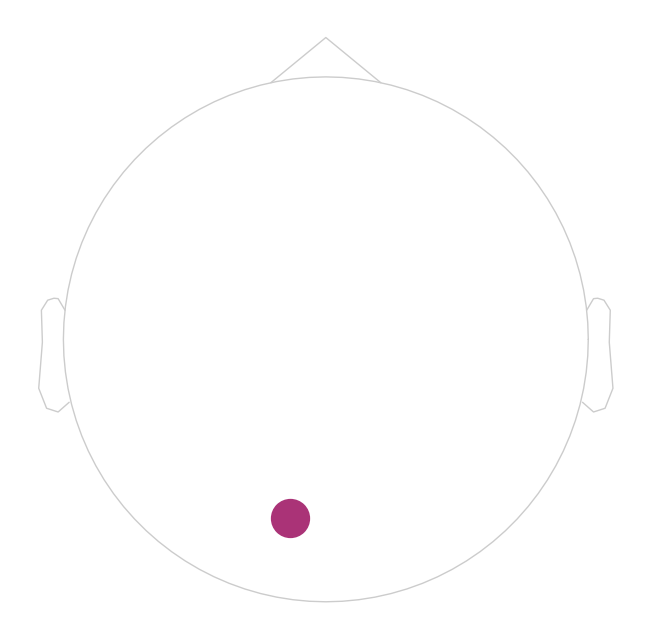

In [53]:
# Plot sensors of interest

import mne
import matplotlib.pyplot as plt
import os.path as op

# Use the info from your existing data
proc_path = '../../processed'
fname = op.join(proc_path, f'205_1_001_long_hbo_final_raw.fif')
use = mne.io.read_raw_fif(fname, preload=True)
use.load_data()
info = use.copy().info

# Specify the names of the sensors you want to plot
selected_sensors = ['S25_D14 hbo']
valid_sensors = [sensor for sensor in selected_sensors if sensor in info['ch_names']]

if not valid_sensors:
    print("No valid sensors selected for plotting.")
else:
    # Increase the font size for sensor names
    plt.rcParams.update({'font.size': 20})  # Set the desired font size

    # Pick only the selected channels
    info_picked = mne.pick_info(info, mne.pick_channels(info['ch_names'], valid_sensors))
    info_picked.rename_channels({ch: '  ' + ch for ch in info_picked['ch_names']})

    # Plot the sensors manually with blue circles
    fig = mne.viz.plot_sensors(info_picked, kind='topomap', show_names=False, pointsize=800, linewidth=0)

    plt.show()



Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


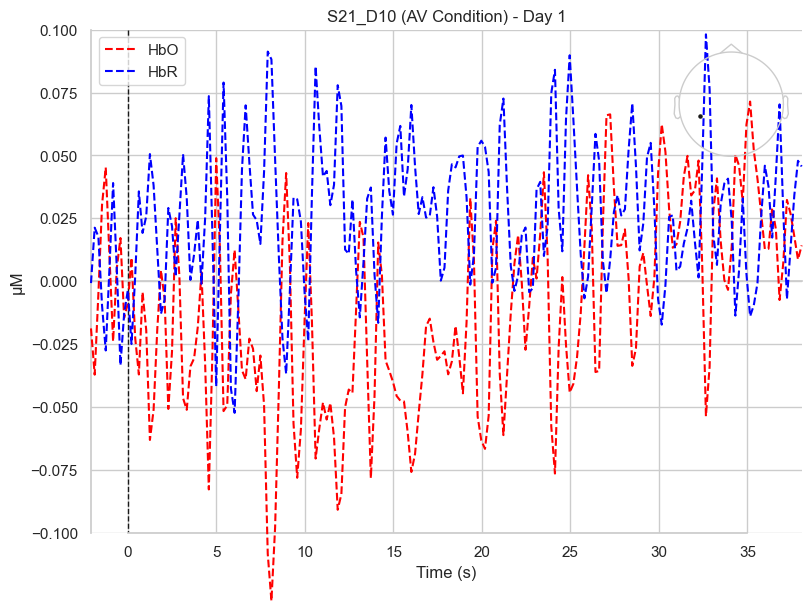

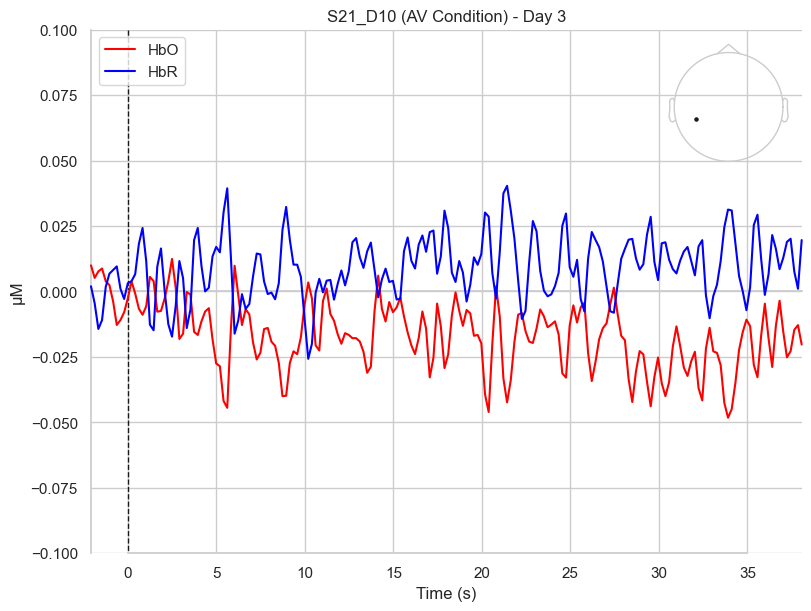

All participants were included in the Day 1 analysis.
All participants were included in the Day 3 analysis.


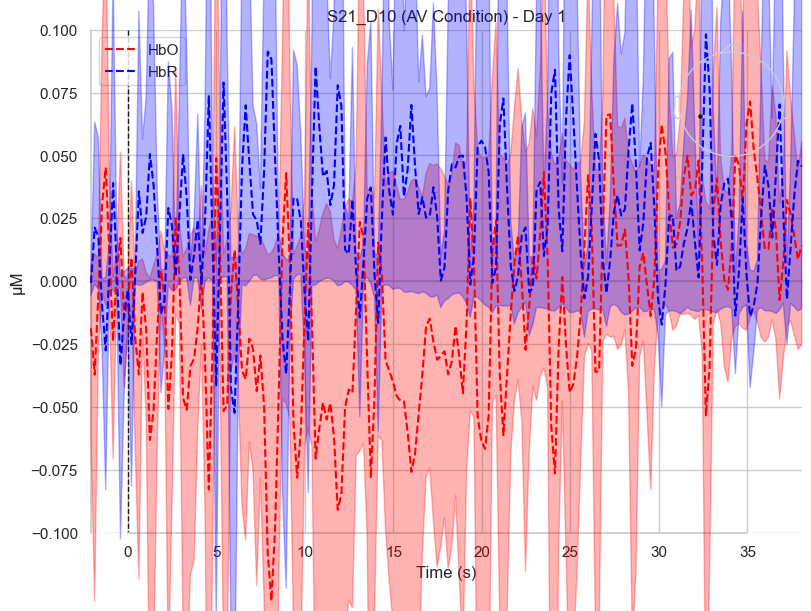

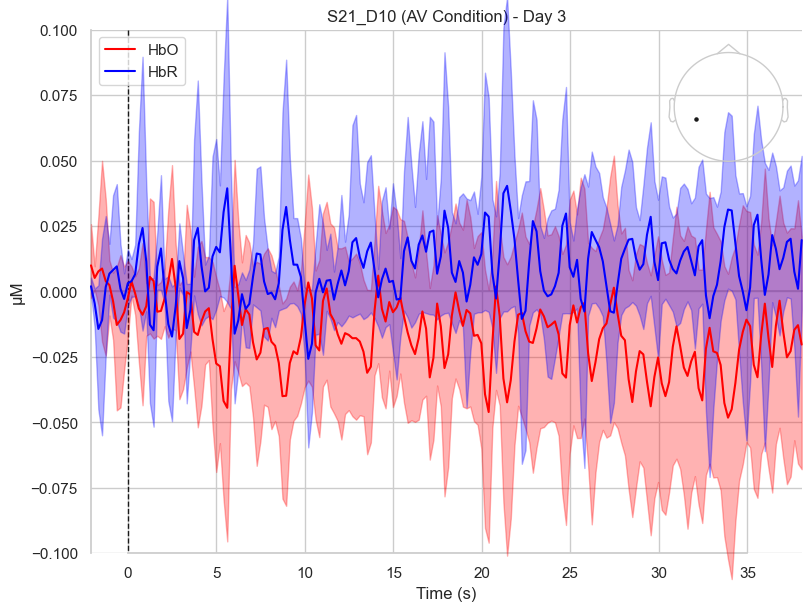

[<Figure size 800x600 with 2 Axes>]

In [55]:
# Plot some waveforms

import mne
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load subject group mapping
subject_group_mapping = pd.read_csv('../../subject_group_mapping.csv')
subject_group_mapping['Subject'] = subject_group_mapping['Subject'].astype(str).str.strip().str.split('.').str[0]
subject_to_group = dict(zip(subject_group_mapping['Subject'], subject_group_mapping['Group']))

# Ensure all subjects are in string format without decimals
subjects = subject_group_mapping['Subject'].tolist()
#subjects = [subject for subject in subjects if subject not in ['202', '203', '204', '206', '214', '221', '223', '226', '233']]

# Define the subjects in the 'trained' group
trained_subjects = [subject for subject in subjects if subject_to_group[subject] == 'control']

# Specify the channel of interest
channel_of_interest = 'S21_D10'
condition = 'AV'

# Initialize the dictionaries to store evoked data for averaging and plotting
evoked_dict_day1 = {'HbO': [], 'HbR': []}
evoked_dict_day3 = {'HbO': [], 'HbR': []}

# Loop over subjects and load their evoked data
for subject in trained_subjects:
    for day in ['1', '3']:
        # Define the filename
        fname = op.join(proc_path, f'{subject}_{day}_final-ave.fif')
        
        # Load the evoked data
        evokeds = mne.read_evokeds(fname, condition=condition, baseline=(None, 0), verbose=False)
                
        # Pick the HbO and HbR data for the channel of interest
        evoked_hbo = evokeds.copy().pick([f'{channel_of_interest} hbo'])
        evoked_hbr = evokeds.copy().pick([f'{channel_of_interest} hbr'])
        
        evoked_hbo.rename_channels(lambda x: x[:-4])
        evoked_hbr.rename_channels(lambda x: x[:-4])
        
        # Check if both HbO and HbR data exist for this subject and day
        if len(evoked_hbo.ch_names) == 1 and len(evoked_hbr.ch_names) == 1:
            # Store in the appropriate evoked dictionary
            if day == '1':
                evoked_dict_day1['HbO'].append(evoked_hbo)
                evoked_dict_day1['HbR'].append(evoked_hbr)
            elif day == '3':
                evoked_dict_day3['HbO'].append(evoked_hbo)
                evoked_dict_day3['HbR'].append(evoked_hbr)

# Compute grand average for Day 1 and Day 3
grand_avg_day1_hbo = mne.grand_average(evoked_dict_day1['HbO'])
grand_avg_day1_hbr = mne.grand_average(evoked_dict_day1['HbR'])
grand_avg_day3_hbo = mne.grand_average(evoked_dict_day3['HbO'])
grand_avg_day3_hbr = mne.grand_average(evoked_dict_day3['HbR'])

# Prepare the grand average dictionary for plotting
grand_avg_dict_day1 = {'HbO': grand_avg_day1_hbo, 'HbR': grand_avg_day1_hbr}
grand_avg_dict_day3 = {'HbO': grand_avg_day3_hbo, 'HbR': grand_avg_day3_hbr}

# Define the colors and styles
color_dict_day1 = {'HbO': 'red', 'HbR': 'blue'}
color_dict_day3 = {'HbO': 'red', 'HbR': 'blue'}
styles_dict_day1 = {'HbO': {'linestyle': '--'}, 'HbR': {'linestyle': '--'}}
styles_dict_day3 = {'HbO': {'linestyle': '-'}, 'HbR': {'linestyle': '-'}}

# Plot for Day 1 using the grand average
mne.viz.plot_compare_evokeds(
    grand_avg_dict_day1,
    ci=0.95, colors=color_dict_day1, styles=styles_dict_day1,
    title=f'{channel_of_interest} ({condition} Condition) - Day 1', show=True,
    truncate_xaxis=(-2, 15),  # This line sets the x-axis limits
    ylim=dict(hbo=(-0.10, 0.10))  # This line sets the y-axis limits
)

# Plot for Day 3 using the grand average
mne.viz.plot_compare_evokeds(
    grand_avg_dict_day3,
    ci=0.95, colors=color_dict_day3, styles=styles_dict_day3,
    title=f'{channel_of_interest} ({condition} Condition) - Day 3', show=True,
    truncate_xaxis=(-2, 15),  # This line sets the x-axis limits
    ylim=dict(hbo=(-0.10, 0.10))  # This line sets the y-axis limits
)

# Initialize the dictionaries to store evoked data for plotting
evoked_dict_day1 = {'HbO': [], 'HbR': []}
evoked_dict_day3 = {'HbO': [], 'HbR': []}

# Loop over subjects and load their evoked data
for subject in trained_subjects:
    for day in ['1', '3']:
        # Define the filename
        fname = op.join(proc_path, f'{subject}_{day}_final-ave.fif')
        
        # Load the evoked data
        evokeds = mne.read_evokeds(fname, condition=condition, baseline=(None, 0), verbose=False)
                
        # Pick the HbO and HbR data for the channel of interest
        evoked_hbo = evokeds.copy().pick([f'{channel_of_interest} hbo'])
        evoked_hbr = evokeds.copy().pick([f'{channel_of_interest} hbr'])
        
        evoked_hbo.rename_channels(lambda x: x[:-4])
        evoked_hbr.rename_channels(lambda x: x[:-4])
        
        # Check if both HbO and HbR data exist for this subject and day
        if len(evoked_hbo.ch_names) == 1 and len(evoked_hbr.ch_names) == 1:
            # Store in the appropriate evoked dictionary
            if day == '1':
                evoked_dict_day1['HbO'].append(evoked_hbo)
                evoked_dict_day1['HbR'].append(evoked_hbr)
            elif day == '3':
                evoked_dict_day3['HbO'].append(evoked_hbo)
                evoked_dict_day3['HbR'].append(evoked_hbr)

# Check if all participants were included
expected_subjects = len(trained_subjects)
actual_subjects_day1 = len(evoked_dict_day1['HbO'])  # Same number for HbO and HbR
actual_subjects_day3 = len(evoked_dict_day3['HbO'])  # Same number for HbO and HbR

if actual_subjects_day1 != expected_subjects:
    print(f"Warning: Only {actual_subjects_day1} out of {expected_subjects} subjects were included in the Day 1 analysis.")
else:
    print("All participants were included in the Day 1 analysis.")

if actual_subjects_day3 != expected_subjects:
    print(f"Warning: Only {actual_subjects_day3} out of {expected_subjects} subjects were included in the Day 3 analysis.")
else:
    print("All participants were included in the Day 3 analysis.")

# Define the colors and styles
color_dict_day1 = {'HbO': 'red', 'HbR': 'blue'}
color_dict_day3 = {'HbO': 'red', 'HbR': 'blue'}
styles_dict_day1 = {'HbO': {'linestyle': '--'}, 'HbR': {'linestyle': '--'}}
styles_dict_day3 = {'HbO': {'linestyle': '-'}, 'HbR': {'linestyle': '-'}}

# Plot for Day 1 using the individual evoked responses
mne.viz.plot_compare_evokeds(
    {'HbO': evoked_dict_day1['HbO'], 'HbR': evoked_dict_day1['HbR']},
    ci=0.95, colors=color_dict_day1, styles=styles_dict_day1,
    title=f'{channel_of_interest} ({condition} Condition) - Day 1', show=True,
    truncate_xaxis=(-2, 15),  # This line sets the x-axis limits
    ylim=dict(hbo=(-0.10, 0.10))  # This line sets the y-axis limits
)

# Plot for Day 3 using the individual evoked responses
mne.viz.plot_compare_evokeds(
    {'HbO': evoked_dict_day3['HbO'], 'HbR': evoked_dict_day3['HbR']},
    ci=0.95, colors=color_dict_day3, styles=styles_dict_day3,
    title=f'{channel_of_interest} ({condition} Condition) - Day 3', show=True,
    truncate_xaxis=(-2, 15),  # This line sets the x-axis limits
    ylim=dict(hbo=(-0.10, 0.10))  # This line sets the y-axis limits
)


In [ ]:
# Compare thetas in 2 specific channels

# Filter data for the specific channels you want to compare
channels_to_analyze = ['S19_D6', 'S15_D14']

from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning) # type: ignore
warnings.filterwarnings("ignore", category=UserWarning) # type: ignore

# Load the datasets
behavior_df = pd.read_csv(behavior_file)
behavior_df['subject'] = behavior_df['subject'].astype(str)

theta_df_filtered = df_final.copy()
theta_df_filtered['subject'] = theta_df_filtered['subject'].astype(str)

# Pivot table to get both Day 1 theta and theta_diff (Day 3 - Day 1)
theta_df_filtered = theta_df_filtered.pivot_table(index=['subject', 'group', 'Condition', 'Chroma', 'ch_name'], columns='day', values='theta').reset_index()
theta_df_filtered['theta_diff'] = theta_df_filtered[3] - theta_df_filtered[1]  # Calculate theta_diff
theta_df_filtered['theta_baseline'] = theta_df_filtered[1]  # Baseline theta (Day 1)
theta_df_filtered = theta_df_filtered[theta_df_filtered['group'] != 'unknown']


def perform_channel_comparison(group, output_suffix):
    # Initialize a list to store significant models
    theta_df_filtered['ch_name'] = theta_df_filtered['ch_name'].str.split(' ').str[0]
    significant_models = []
    
    # Iterate over each condition and chroma
    for chroma in chromas:
        all_p_values = []
        model_data = []

        for condition in conditions:
            print(f"\nStarting analysis for condition: {condition}, chroma: {chroma}, group: {group}\n")
            # Filter the dataset for the current condition and chroma
            theta_df_condition = theta_df_filtered[(theta_df_filtered['Chroma'] == chroma) & (theta_df_filtered['Condition'] == condition)]
            
            # Pivot the theta_df to have channel names as columns
            theta_pivot = theta_df_condition.pivot_table(index=['subject', 'group'], columns='ch_name', values=['theta_diff', 'theta_baseline'])
            theta_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in theta_pivot.columns.values]  # Flatten the MultiIndex
            
            # Reset the index to make 'group' a column again
            theta_pivot.reset_index(inplace=True)

            # Ensure both channels are in the pivoted dataframe
            if f'theta_diff_S19_D6' in theta_pivot.columns and f'theta_diff_S15_D14' in theta_pivot.columns:
                df = theta_pivot[[f'theta_diff_S19_D6', f'theta_diff_S15_D14', f'theta_baseline_S19_D6', f'theta_baseline_S15_D14', 'group']].dropna()
                
                if df.empty:
                    print("  No data available for the selected channels, skipping.")
                    continue  # Skip this condition if there is no data

                # Perform regression analysis for S19_D6 vs. S20_D10
                model = smf.ols(f"theta_diff_S15_D14 ~ theta_diff_S19_D6", df[df['group'] == group]).fit()
                r_sq = model.rsquared
                p_value_channel = model.pvalues[f'theta_diff_S19_D6']

                # Collect p-values and models for FDR correction
                all_p_values.append(p_value_channel)
                model_data.append((condition, 'S19_D6_vs_S15_D14', r_sq, p_value_channel, model, chroma, df))
            else:
                print(f"  One or both channels S19_D6 and S15_D14 are missing for condition {condition}, skipping.")
                continue  # Skip this condition if there is no data

        # Apply FDR correction
        if len(all_p_values) > 0:
            rejected, p_values_corrected, _, _ = multipletests(all_p_values, alpha=0.05, method='fdr_bh')

        # Filter results based on FDR corrected p-values and plot only if significant
        for i, (condition, comparison, r_sq, p_value, model, chroma, df) in enumerate(model_data):
            if p_values_corrected[i] < 0.05:
                print(f"Comparison: {comparison}, {condition}, chroma: {chroma}, group: {group}")
                print(f"   p-value: {p_value}, corrected p-value: {p_values_corrected[i]}, R-squared: {r_sq}\n")
                
                significant_models.append({
                    'Condition': condition,
                    'Comparison': comparison,
                    'R-squared': r_sq,
                    'P-value': p_value,
                    'P-value Corrected': p_values_corrected[i],
                    'Model Summary': model.summary().as_text(),
                    'Chroma': chroma,
                    'Group': group
                })

                # Plot the significant results
                plt.figure(figsize=(8, 6))
                sns.scatterplot(x=df[f'theta_diff_S19_D6'], y=df[f'theta_diff_S15_D14'], hue=df['group'], palette=['#92b6f0', 'gray'], s=100)
                sns.lineplot(x=df[f'theta_diff_S19_D6'], y=model.predict(df), color='black', linewidth=2)

                xlabel = f'{chroma.upper()} Change in S19_D6 (Day 3 - Day 1)'
                ylabel = f'{chroma.upper()} Change in S15_D14 (Day 3 - Day 1)'
                plt.xlabel(xlabel, fontsize=16)
                plt.ylabel(ylabel, fontsize=16)
                plt.title(f'Comparison of {xlabel} and {ylabel} in {condition} condition', fontsize=16)
                plt.legend(title='Group', loc='upper right')
                plt.savefig(op.join(results_path, f'{output_suffix}__{group}_{chroma}_{condition}_S19_D6_vs_S15_D14_plot.png'))
                plt.close()

    # Save significant models to CSV
    if significant_models:
        significant_models_df = pd.DataFrame(significant_models).sort_values(by='R-squared', ascending=False)
        csv_file = op.join(results_path, f'{output_suffix}_{group}_models.csv')
        if not op.isfile(csv_file):
            significant_models_df.to_csv(csv_file, index=False, mode='w')
        else:
            significant_models_df.to_csv(csv_file, index=False, mode='a', header=False)
    else:
        print(f'No significant models found for group {group}')

# Perform the comparison analysis for the trained group
perform_channel_comparison('trained', 'S19_D6_vs_S15_D14_comparison')



In [ ]:
GO HERE:

Opening raw data file ../../processed/205_1_001_long_hbo_final_raw.fif...
    Range : 0 ... 4171 =      0.000 ...   867.568 secs
Ready.
Reading 0 ... 4171  =      0.000 ...   867.568 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Correcting for 420 comparisons using FDR
Empty DataFrame
Columns: [ch_name, Condition, t_stat, p_value, z, P_fdr, SIG]
Index: []
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Projecting data from 84 sensors onto 327684 surface vertices: weighted mode
    Projecting sensors onto surface
    Minimum projected intra-sensor distance: 6.1 mm
    160208 / 327684 non-zero vertices


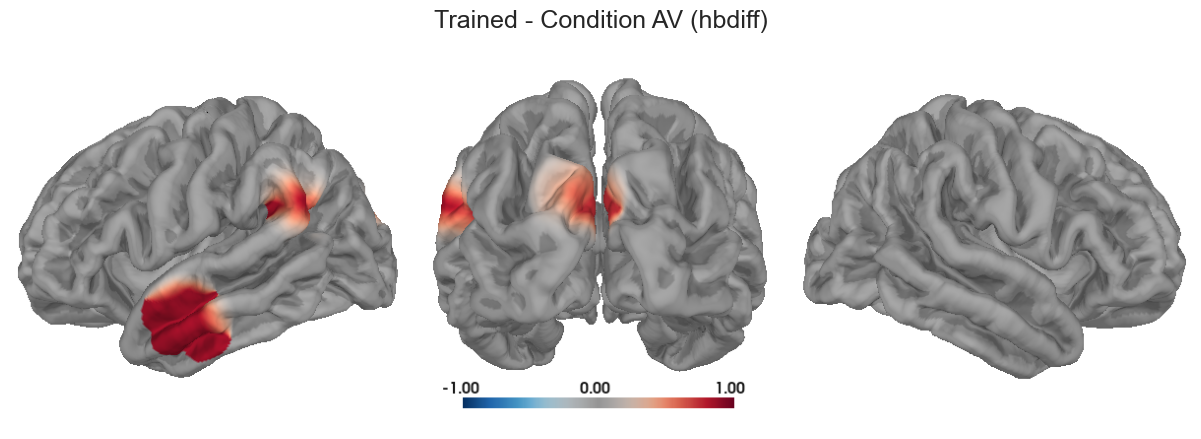

In [104]:
# Run paired t-test over days and plot changes over time
# !!!!!!!!!!!!!!!!!!

# Load the final combined dataframe
#df_final = pd.read_csv(op.join(results_path, f'df_combined_final_cha_{output_suffix}.csv'))
conditions = ['AV']
groups = ['trained']
chromas = ['hbdiff']

df_final['ch_name'] = df_final['ch_name'].str.split(' ').str[0]
fname = op.join(proc_path, f'205_1_001_long_hbo_final_raw.fif')
use = mne.io.read_raw_fif(fname, preload=True)
use.load_data()
new_ch_names = {}
seen_names = set()
for ch_name in use.info['ch_names']:
    new_name = ch_name.split(' ')[0]
    if new_name not in seen_names:
        new_ch_names[ch_name] = new_name
        seen_names.add(new_name)

use.rename_channels(new_ch_names)
use = use.pick_channels(list(new_ch_names.values()))

# Perform analysis for each group and Chroma
for group in groups:
    for chroma in chromas:
        # Prepare figure for composite plots
        fig, axes = plt.subplots(1, len(conditions), figsize=(15, 5))
        for idx, condition in enumerate(conditions):
            # Filter data for day 1 and day 3 for the specific group and Chroma
            df_day1 = df_final.query(f"group == '{group}' and Chroma == '{chroma}' and day == 1").copy()
            df_day3 = df_final.query(f"group == '{group}' and Chroma == '{chroma}' and day == 3").copy()

            # Ensure ch_name and Condition columns are of the same data type
            df_day1['ch_name'] = df_day1['ch_name'].astype(str)
            df_day1['Condition'] = df_day1['Condition'].astype(str)
            df_day3['ch_name'] = df_day3['ch_name'].astype(str)
            df_day3['Condition'] = df_day3['Condition'].astype(str)

            # Set index and sort
            df_day1 = df_day1.set_index(['subject', 'group', 'ch_name', 'Condition', 'Chroma']).sort_index()
            df_day3 = df_day3.set_index(['subject', 'group', 'ch_name', 'Condition', 'Chroma']).sort_index()

            # Merge dataframes to align day 1 and day 3 data
            df_merged = df_day1[['theta']].rename(columns={'theta': 'theta_day1'}).merge(
                df_day3[['theta']].rename(columns={'theta': 'theta_day3'}),
                left_index=True, right_index=True)

            # Calculate the difference and z-score
            df_merged['theta_diff'] = df_merged['theta_day3'] - df_merged['theta_day1']
            df_merged['z'] = zscore(df_merged['theta_diff'])

            # Perform paired t-test for each channel and condition across subjects
            t_stats = []
            p_values = []
            ch_names = []
            condition_list = []

            for (ch_name, cond), group_df in df_merged.groupby(['ch_name', 'Condition']):
                t_stat, p_value = ttest_rel(group_df['theta_day1'], group_df['theta_day3'])
                t_stats.append(t_stat)
                p_values.append(p_value)
                ch_names.append(ch_name)
                condition_list.append(cond)

            # Create a results DataFrame
            results_df = pd.DataFrame({
                'ch_name': ch_names,
                'Condition': condition_list,
                't_stat': t_stats,
                'p_value': p_values
            })

            # Combine with z-score data
            z_scores = df_merged.groupby(['ch_name', 'Condition'])['z'].mean().reset_index()
            
            # Ensure consistent data types before merging
            z_scores['ch_name'] = z_scores['ch_name'].astype(str)
            z_scores['Condition'] = z_scores['Condition'].astype(str)
            results_df['ch_name'] = results_df['ch_name'].astype(str)
            results_df['Condition'] = results_df['Condition'].astype(str)

            results_df = results_df.merge(z_scores, on=['ch_name', 'Condition'])

            # Correct for multiple comparisons
            print(f'Correcting for {len(results_df["p_value"])} comparisons using FDR')
            _, results_df['P_fdr'] = mne.stats.fdr_correction(results_df['p_value'], method='indep')
            results_df['SIG'] = results_df['P_fdr'] < 0.05
            
            # Print significant results
            significant_results = results_df.loc[results_df.SIG == True]
            print(significant_results)

            # Prepare data for brain plots
            ch_of_interest = use.pick_channels([ch_name for ch_name in use.info['ch_names']])
            info_of_interest = ch_of_interest.info

            zs = {}
            condition_data = results_df[(results_df['Condition'] == condition)]
                        
            zs[condition] = np.array([
                condition_data.loc[(condition_data['ch_name'] == ch_name), 'z'].values[0]

                if not condition_data.loc[(condition_data['ch_name'] == ch_name), 'z'].empty and condition_data.loc[(condition_data['ch_name'] == ch_name), 'p_value'].values[0] < 0.05
                else 0
                for ch_name in condition_data['ch_name']
            ])

### NEW 
            highlight_channels = ['S15_D14', 'S19_D4', 'S21_D10']  # Specify the channels you want to highlight
            highlight_values = np.zeros(len(info_of_interest['ch_names']))
            highlight_values_dict = {
                'S15_D14': 0.7367077245612972,  # R² for S15_D14 hbo
                'S19_D4': 0.8657075815562162,   # R² for S19_D4 hbo
                'S21_D10': 0.851818535397406    # R² for S21_D10 hbo
            }

            # Set the values for the highlight channels
            for ch_name, highlight_value in highlight_values_dict.items():
                if ch_name in info_of_interest['ch_names']:
                    idx = info_of_interest['ch_names'].index(ch_name)
                    highlight_values[idx] = highlight_value

            # Create an EvokedArray for each condition
            evoked = mne.EvokedArray(highlight_values[:, np.newaxis], info_of_interest)
            picks = np.arange(len(info_of_interest['ch_names']))

            # Create the source time course (STC) and highlight specific channels
            stc = mne.stc_near_sensors(
                evoked, trans='fsaverage', subject='fsaverage', mode='weighted',
                distance=0.02, project=True, picks=picks, subjects_dir=subjects_dir)

### NEW
            # Plot the brain and capture the image in-memory
            brain = stc.plot(hemi='both', views=['lat', 'frontal', 'lat'],
                             cortex='low_contrast', time_viewer=False, show_traces=False,
                             surface='pial', smoothing_steps=0, size=(1200, 400),
                             clim=dict(kind='value', pos_lims=[0, 0.5, 1.0]),
                             colormap='RdBu_r', view_layout='horizontal',
                             colorbar=(0, 1), time_label='', background='w',
                             brain_kwargs=dict(units='m'),
                             add_data_kwargs=dict(colorbar_kwargs=dict(
                                 title_font_size=12, label_font_size=8, n_labels=3,
                                 title='   ')), subjects_dir=subjects_dir)
            brain.show_view('lat', hemi='lh', row=0, col=0)
            brain.show_view(azimuth=270, elevation=90, row=0, col=1)
            brain.show_view('lat', hemi='rh', row=0, col=2)

            # Capture the plot as an image in memory
            screenshot = brain.screenshot(time_viewer=False)
            brain.close()

            # Display the image in the composite figure
            ax = axes
            ax.imshow(screenshot)
            ax.axis('off')
            ax.set_title(f'{group.capitalize()} - Condition {condition} ({chroma})', fontsize=18)

            del df_day1, df_day3, df_merged, t_stats, p_values, ch_names, condition_list, results_df, z_scores
            gc.collect()  #

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(op.join(results_path, f'{group}_{chroma}_composite_brain_plots_FDRinsig.png'))
        plt.show()
        plt.close(fig)

        del fig, axes, ch_of_interest, info_of_interest, evoked, stc, brain, screenshot
        gc.collect()  #


In [88]:
mne.set_log_level('info')

In [ ]:
""" # Plot topographic maps of significant models

for group in groups:
    df_r2 = pd.read_csv(op.join(results_path, f'{group}_fnirs-behavior-models_{group}.csv'))
    df_filtered = df_r2[(df_r2['P-value Corrected'] < 0.05)]
    ch_names = df_filtered['Channel'].values 
    info = use.copy().pick_types(fnirs='hbo', exclude=())
    info_picked = info.pick_channels(ch_names)
    fig = mne.viz.plot_sensors(info_picked.info, kind='topomap', show_names=True, pointsize=100, linewidth=0]
    plt.savefig(op.join(results_path, f'{group}_sig-p-corr_topomap.png'))
    plt.show()
    plt.close(fig)
 """

In [ ]:
#### ROI AND CHANNEL T-TESTS

# Define ROIs and their corresponding channels
import gc
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as op
import time
import pandas as pd
import glob
import csv
import mne
from mne.preprocessing.nirs import tddr
from nilearn.glm.first_level import make_first_level_design_matrix  
from mne_nirs.channels import get_long_channels
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from scipy import signal
from scipy.stats import ttest_rel, zscore
import mne_nirs

mne.set_config('SUBJECTS_DIR', None)
mne.set_config('SUBJECTS_DIR', '/Users/ansle/Documents/Github/fnirs-analysis/subjects', set_env=True)

results_path = '../../results'
proc_path = '../../processed'
df_final = pd.read_csv(op.join(results_path, f'df_combined_final_cha_final.csv'))
df_final['ch_name'] = df_final['ch_name'].str.split(' ').str[0]
output_csv_path = op.join(results_path, 'correlations/roi_ttest_results.csv')

# Define ROIs and their corresponding channels
roi_channels = {
    'STG': ['S10_D20', 'S19_D6', 'S12_D22', 'S21_D8', 'S12_D20', 'S12_D24', 'S21_D10', 'S21_D6', 'S8_D20'],
    'V1': ['S25_D14', 'S16_D14', 'S15_D14', 'S17_D14', 'S16_D25', 'S25_D11', 'S25_D13', 'S15_D25', 
           'S16_D27', 'S25_D12', 'S15_D11', 'S16_D26'],
    'V2': ['S16_D26', 'S15_D25', 'S25_D12', 'S15_D11', 'S25_D13', 'S16_D27', 'S25_D11', 'S16_D25', 
           'S17_D14', 'S15_D14', 'S16_D14', 'S25_D14', 'S13_D25', 'S17_D13', 'S24_D11', 'S17_D27'],
    'V3': ['S24_D11', 'S14_D26', 'S13_D25', 'S23_D12', 'S18_D26', 'S26_D12', 'S24_D9', 'S13_D23', 
           'S23_D10', 'S25_D12', 'S15_D11', 'S24_D10', 'S15_D25', 'S14_D24', 'S13_D24', 'S16_D26'],
    'AC': ['S21_D6'],
    'MTG': ['S10_D18', 'S19_D4', 'S10_D22', 'S19_D8', 'S10_D20', 'S19_D6', 'S12_D22', 'S21_D8', 
            'S21_D10', 'S14_D22', 'S12_D24']
}

# Define conditions, groups, and chromas
conditions = ['A', 'AV', 'V']
groups = ['trained', 'control']
chromas = ['hbo', 'hbr', 'hbdiff']

""" 
# Prepare for output
output_csv_path = op.join(results_path, 'correlations/roi_ttest_results.csv')
all_results_df = pd.DataFrame()

# Perform analysis for each group, chroma, and ROI
for group in groups:
    for chroma in chromas:
        for roi_name, channels in roi_channels.items():
            for condition in conditions:
                # Filter data for day 1 and day 3 for the specific group, chroma, and ROI channels
                df_day1 = df_final.query(f"group == '{group}' and Chroma == '{chroma}' and day == 1 and Condition == '{condition}' and ch_name in {channels}").copy()
                df_day3 = df_final.query(f"group == '{group}' and Chroma == '{chroma}' and day == 3 and Condition == '{condition}' and ch_name in {channels}").copy()

                # Ensure 'ch_name' and 'Condition' columns are of the same data type
                df_day1['ch_name'] = df_day1['ch_name'].astype(str)
                df_day1['Condition'] = df_day1['Condition'].astype(str)
                df_day3['ch_name'] = df_day3['ch_name'].astype(str)
                df_day3['Condition'] = df_day3['Condition'].astype(str)

                # Set index and sort
                df_day1 = df_day1.set_index(['subject', 'group', 'Condition', 'Chroma', 'ch_name']).sort_index()
                df_day3 = df_day3.set_index(['subject', 'group', 'Condition', 'Chroma', 'ch_name']).sort_index()

                # Merge day 1 and day 3 data
                df_merged = df_day1[['theta']].rename(columns={'theta': 'theta_day1'}).merge(
                    df_day3[['theta']].rename(columns={'theta': 'theta_day3'}),
                    left_index=True, right_index=True)

                # Average across channels in the ROI (for each subject, condition, and chroma)
                df_merged = df_merged.groupby(['subject', 'Condition', 'Chroma']).agg({
                    'theta_day1': 'mean',
                    'theta_day3': 'mean'}).reset_index()

                # Before performing the t-test, print some diagnostic information
                print(f"Analyzing ROI: {roi_name}, Condition: {condition}, Group: {group}, Chroma: {chroma}")

                # Perform paired t-test
                t_stat, p_value = ttest_rel(df_merged['theta_day1'], df_merged['theta_day3'])

                # Create a results DataFrame for this ROI and condition
                results_df = pd.DataFrame({
                    'ROI': [roi_name],
                    'Group': [group],
                    'Condition': [condition],
                    'Chroma': [chroma],
                    't_stat': [t_stat],
                    'p_value': [p_value],
                })
                
                # Only concatenate significant results
                if p_value < 0.05:
                    print(results_df) 
                    all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)
                    
# Save the final results to a CSV
all_results_df.to_csv(output_csv_path, index=False)

""" 
""" 
output_csv_path = op.join(results_path, 'correlations/channel_ttest_results.csv')
all_results_df = pd.DataFrame()
results_list = []

# Perform analysis for each group, chroma, and channel
for group in groups:
    for chroma in chromas:
        for condition in conditions:
            for channel in df_final['ch_name'].unique():
                # Filter data for day 1 and day 3 for the specific group, chroma, condition, and channel
                df_day1 = df_final.query(f"group == '{group}' and Chroma == '{chroma}' and day == 1 and Condition == '{condition}' and ch_name == '{channel}'").copy()
                df_day3 = df_final.query(f"group == '{group}' and Chroma == '{chroma}' and day == 3 and Condition == '{condition}' and ch_name == '{channel}'").copy()

                # Ensure 'ch_name' and 'Condition' columns are of the same data type
                df_day1['ch_name'] = df_day1['ch_name'].astype(str)
                df_day1['Condition'] = df_day1['Condition'].astype(str)
                df_day3['ch_name'] = df_day3['ch_name'].astype(str)
                df_day3['Condition'] = df_day3['Condition'].astype(str)

                # Set index and sort by subject, group, condition, chroma, and channel
                df_day1 = df_day1.set_index(['subject', 'group', 'Condition', 'Chroma', 'ch_name']).sort_index()
                df_day3 = df_day3.set_index(['subject', 'group', 'Condition', 'Chroma', 'ch_name']).sort_index()

                # Check if any data was retrieved
                if df_day1.empty or df_day3.empty:
                    continue

                # Merge day 1 and day 3 data
                df_merged = df_day1[['theta']].rename(columns={'theta': 'theta_day1'}).merge(
                    df_day3[['theta']].rename(columns={'theta': 'theta_day3'}),
                    left_index=True, right_index=True)

                # Ensure there are no missing values or nan issues
                if df_merged.empty or df_merged['theta_day1'].isnull().all() or df_merged['theta_day3'].isnull().all():
                    continue

                # Perform paired t-test by subject for each channel
                t_stat, p_value = ttest_rel(df_merged['theta_day1'], df_merged['theta_day3'])

                # If significant, store the z-score (based on the t-statistic)
                if p_value < 0.05:
                    # Store the significant channel information
                    results_list.append({
                        'Channel': channel,
                        'Group': group,
                        'Condition': condition,
                        'Chroma': chroma,
                        'z_score': t_stat,
                        'p_value': p_value
                    })


# Convert results_list to DataFrame
significant_channels_df = pd.DataFrame(results_list)
significant_channels_df.to_csv(output_csv_path, index=False)
 """


import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os.path as op  # Import os.path as op

# Load dataframes
results_path = '../../results'
df_combined_final = pd.read_csv(op.join(results_path, 'df_combined_final_cha_final.csv'))
df_combined_final['ch_name'] = df_combined_final['ch_name'].astype(str).str.strip().str.split(' ').str[0]

# Further filter to only include 'control' and 'trained' groups
filtered_df = df_combined_final[df_combined_final['group'].isin(['control', 'trained'])]

# Ensure 'ch_name' and 'Condition' columns are of the same data type
filtered_df['day'] = filtered_df['day'].astype(str)
filtered_df['ch_name'] = filtered_df['ch_name'].astype(str)
filtered_df['Condition'] = filtered_df['Condition'].astype(str)

# Prepare the data for analysis
data = filtered_df[['subject', 'group', 'day', 'ch_name', 'Condition', 'Chroma', 'theta']].copy()
results_list = []

# List of unique chromas and conditions
chromas = data['Chroma'].unique()
conditions = data['Condition'].unique()

# Run mixed-effects model for each combination of chroma and condition
for chroma in filtered_df['Chroma'].unique():
    for condition in filtered_df['Condition'].unique():
        subset = data[(data['Chroma'] == chroma) & (data['Condition'] == condition)]
        
        if subset.empty:
            continue
        
        # Compute mean activity for each ROI
        for roi, channels in roi_channels.items():
            roi_data = subset[subset['ch_name'].isin(channels)]
            
            if roi_data.empty:
                continue
            
            roi_means = roi_data.groupby(['subject', 'group', 'day']).agg({
                'theta': 'mean'
            }).reset_index()
            
            # Run mixed-effects model: day * group interaction
            model = smf.mixedlm('theta ~ day * group', roi_means, groups=roi_means['subject'])
            result = model.fit()
            
            # Extract p-value
            p_values = result.pvalues
            if 'day[T.3]:group[T.trained]' in p_values:
                p_value = p_values['day[T.3]:group[T.trained]']
                results_list.append({
                    'Chroma': chroma,
                    'Condition': condition,
                    'ROI': roi,
                    't_stat': result.tvalues['day[T.3]:group[T.trained]'],
                    'p_value_unadj': p_value,
                    'summary': result.summary().as_text()
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Apply FDR correction separately for each chroma/condition combo
def fdr_correction(group_df):
    p_values = group_df['p_value_unadj'].values
    rejected, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
    group_df['p_value_adj'] = corrected_p_values
    return group_df

# Apply FDR correction separately for each combination of chroma and condition
results_df = results_df.groupby(['Chroma', 'Condition']).apply(fdr_correction).reset_index(drop=True)

# Save results to CSV
results_df.to_csv(op.join(results_path, 'correlations/roi_day_group_interactions_fdr.csv'), index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path as op  # Import os.path as op

# Load dataframes
results_path = '../../results'
df_combined_final = pd.read_csv(op.join(results_path, 'df_combined_final_cha_final.csv'))
df_combined_final['ch_name'] = df_combined_final['ch_name'].astype(str).str.strip().str.split(' ').str[0]
channel_ttest_results = pd.read_csv(op.join(results_path, 'correlations/channel_ttest_results.csv'))
significant_channels = channel_ttest_results['Channel'].unique()

# Filter df_combined_final based on significant channels
filtered_df = df_combined_final[df_combined_final['ch_name'].isin(significant_channels)]

# Further filter to only include 'control' and 'trained' groups
filtered_df = filtered_df[filtered_df['group'].isin(['control', 'trained'])]

# Ensure the two groups exist
groups = filtered_df['group'].unique()
if len(groups) != 2:
    raise ValueError("The dataset should only contain 'control' and 'trained' groups.")

# Unique days present in the data
days = filtered_df['day'].unique()

for channel in significant_channels:
    channel_data = filtered_df[filtered_df['ch_name'] == channel]
    
    if not channel_data.empty:
        # Create a summary DataFrame with means and standard errors for each group and day
        summary_df = channel_data.groupby(['group', 'day'])['theta'].agg(['mean', 'sem']).reset_index()

        # Create figure and axes for the plot
        plt.figure(figsize=(10, 6))

        # Bar width and index setup
        bar_width = 0.35
        index = np.arange(len(groups))
        colors = {'control': 'lightblue', 'trained': 'lightgray'}

        # Loop over days to plot each day's bar
        for i, group in enumerate(groups):
            group_data = summary_df[summary_df['group'] == group]
            plt.bar(index + i * bar_width, group_data['mean'], bar_width,
                    yerr=group_data['sem'], label=f'{group}',
                    color=['lightgray'], alpha=0.75)

        # Set x-axis labels and title
        plt.xlabel('Group')
        plt.ylabel('Mean Theta Difference')
        plt.title(f'Mean Theta Difference by Group and Day with SEM for Channel {channel}')
        plt.xticks(index + bar_width / 2, groups)

        # Add legend and adjust layout
        plt.legend(title='Day')
        plt.tight_layout()
        plt.show()


In [ ]:
def perform_analysis(group, output_suffix):
    significant_models = []
    all_p_values = {condition: {response_var: {chroma: {day: [] for day in days} for chroma in chromas} for response_var in response_vars} for condition in conditions}
    all_model_data = {condition: {response_var: {chroma: {day: [] for day in days} for chroma in chromas} for response_var in response_vars} for condition in conditions}
    max_r_squared = 0
    max_r_squared_model = None

    for day in days:
        theta_df_filtered = theta_df[theta_df['day'] == day].copy()
        theta_df_filtered['ch_name'] = theta_df_filtered['ch_name'].str.split(' ').str[0]

        for chroma in chromas:
            theta_dataset = theta_df_filtered[theta_df_filtered['Chroma'] == chroma].copy()

            # Aggregate channels into ROI activity
            roi_data = pd.DataFrame()
            for roi, channels in roi_channels.items():
                roi_data[roi] = theta_dataset[theta_dataset['ch_name'].isin(channels)].groupby(['subject', 'group', 'Condition'])['theta'].mean()

            # Add ROI data to theta_pivot
            theta_pivot = roi_data.reset_index()

            for condition in conditions:
                for response_var in response_vars:
                    # Ensure response_var exists in the merged DataFrame
                    theta_df_condition = theta_dataset[theta_dataset['Condition'] == condition]
                    
                    # Merge the theta data with behavioral data
                    merged_df = pd.merge(theta_pivot, behavior_df[['subject', 'group', 'TBW', 'AO_WR', 'AV_WR', 'VO_WR', 'age', 'AO_WR_1', 'AV_WR_1', 'VO_WR_1', 'TBW_1']], on=['subject', 'group'])

                    for roi in roi_channels.keys():  # iterate over ROIs instead of individual channels
                        if roi not in merged_df.columns:
                            print(f"Warning: {roi} not in merged DataFrame columns")
                            continue

                        # Ensure response variable exists in merged_df
                        if response_var not in merged_df.columns:
                            print(f"Warning: {response_var} not in merged DataFrame columns")
                            continue

                        df = merged_df[[roi, response_var, 'group']].dropna()  # drop rows with missing values
                        if df.empty:
                            continue

                        model = smf.ols(f"{response_var} ~ {roi}", df[df['group'] == group]).fit()
                        r_sq = model.rsquared
                        p_value_roi = model.pvalues[roi]
                        all_p_values[condition][response_var][chroma][day].append(p_value_roi)
                        all_model_data[condition][response_var][chroma][day].append((condition, roi, response_var, model, r_sq, p_value_roi, df, chroma, day))

                    p_values = all_p_values[condition][response_var][chroma][day]
                    model_data = all_model_data[condition][response_var][chroma][day]

                    if p_values:
                        rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

                        for (condition, roi, response_var, model, r_sq, p_value, df, chroma, day), p_val_corr, reject in zip(model_data, p_values_corrected, rejected):
                            if p_val_corr < 0.05:
                                print(f"Group: {group}, Day: {day}, Chroma: {chroma}, Condition: {condition}, ROI: {roi}, Outcome: {response_var}\n   R-squared: {r_sq}, corrected p-value: {p_val_corr}\n")
                                significant_models.append({
                                    'Condition': condition,
                                    'ROI': roi,
                                    'Response Variable': response_var,
                                    'R-squared': r_sq,
                                    'P-value': p_value,
                                    'P-value Corrected': p_val_corr,
                                    'Model Summary': model.summary().as_text(),
                                    'Chroma': chroma,
                                    'Day': day
                                })

    if significant_models:
        significant_models_df = pd.DataFrame(significant_models).sort_values(by='R-squared', ascending=False)
        significant_models_df.to_csv(op.join(results_path, f'{output_suffix}_{group}_models.csv'), index=False)
    else:
        print(f'No significant models found for {group} group')

# Perform analysis for the trained group
perform_analysis('trained', output_suffix)

# Perform analysis for the control group
perform_analysis('control', output_suffix)
